In [1]:
#WB
#Q
#lamb_fact
#eps_conv
import numpy as np
import math
T=5
NX=4
NU=2
DT=0.2
WB=5
MAX_STEER = np.deg2rad(45.0)  # maximum steering angle [rad]
MAX_DSTEER = np.deg2rad(30.0)  # maximum steering speed [rad/s]
MAX_SPEED = 25#55.0 / 3.6  # maximum speed [m/s]
MIN_SPEED = -25#-20.0 / 3.6  # minimum speed [m/s]
MAX_ACCEL = 5.0  # maximum accel [m/ss]
class State:
     
    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.predelta = None
    def array(self):
        return np.array([self.x,self.y,self.v,self.yaw],dtype=np.float64)
class Motion():

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.state=State(x=x, y=y, yaw=yaw, v=v)
        
    def get_state(self):
        return State(x=self.state.x, y=self.state.y, yaw=self.state.yaw, v=self.state.v)
        
    def set_state(self,state):
        self.state=State(x=state.x, y=state.y, yaw=state.yaw, v=state.v)
    def get_next_state(self, a, delta, curr_state=-1):
        if curr_state==-1:
            curr_state=self.state
        # input check
        if delta >= MAX_STEER:
            delta = MAX_STEER
        elif delta <= -MAX_STEER:
            delta = -MAX_STEER

        next_x = curr_state.x + curr_state.v * math.cos(curr_state.yaw) * DT
        next_y = curr_state.y + curr_state.v * math.sin(curr_state.yaw) * DT
        next_yaw = curr_state.yaw + curr_state.v / WB * math.tan(delta) * DT
        next_v = curr_state.v + a * DT
        #print(curr_state.v,a,DT,next_v)
        if next_v > MAX_SPEED:
            next_v = MAX_SPEED
        elif next_v < MIN_SPEED:
            next_v = MIN_SPEED

        return State(x=next_x,y=next_y,v=next_v,yaw=next_yaw)
    
    def _get_next_state(self, a, delta, curr_state=-1):
        if curr_state==-1:
            curr_state=self.state
        # input check
        if delta >= MAX_STEER:
            delta = MAX_STEER
        elif delta <= -MAX_STEER:
            delta = -MAX_STEER
            
        A, B, C = get_linear_model_matrix(curr_state.v, curr_state.yaw, delta)
        
        X=np.array([curr_state.x,curr_state.y,curr_state.v,curr_state.yaw],dtype=np.float64)
        U=np.array([a,delta],dtype=np.float64)
        [next_x,next_y,next_v,next_yaw]=np.matmul(A,X) + np.matmul(B,U)+ C
        
        
        if next_v > MAX_SPEED:
            next_v = MAX_SPEED
        elif next_v < MIN_SPEED:
            next_v = MIN_SPEED

        return State(x=next_x,y=next_y,v=next_v,yaw=next_yaw),[A,B,C]


    def get_trajectory(self,accels, deltas,time_step):
        xbar =np.zeros((NX, time_step + 1))
        xbar[:, 0] = self.state.x,self.state.y,self.state.v,self.state.yaw
        #_state=State(x=state.x,y=state.y,v=state.v,yaw=state.yaw)
        _state=Motion.get_state(self)
        for (accel, delta, i) in zip(accels, deltas, range(1, T + 1)):
            next_state = Motion._get_next_state(self,accel, delta, curr_state=_state)
            xbar[:, i] = next_state.x,next_state.y,next_state.v,next_state.yaw
            _state=next_state
        

        return xbar


    
def get_linear_model_matrix(v, phi, delta):
        A = np.zeros((NX, NX))
        A[0, 0] = 1.0
        A[1, 1] = 1.0
        A[2, 2] = 1.0
        A[3, 3] = 1.0
        A[0, 2] = DT * math.cos(phi)
        A[0, 3] = - DT * v * math.sin(phi)#
        A[1, 2] = DT * math.sin(phi)
        A[1, 3] = DT * v * math.cos(phi)#
        A[3, 2] = DT * math.tan(delta) / WB

        B = np.zeros((NX, NU))
        B[2, 0] = DT
        B[3, 1] = DT * v / (WB * math.cos(delta) ** 2)#

        C = np.zeros(NX)
        C[0] = DT * v * math.sin(phi) * phi
        C[1] = - DT * v * math.cos(phi) * phi
        C[3] = - DT * v * delta / (WB * math.cos(delta) ** 2)
        #C = np.zeros(NX)
        return A, B, C
    
def np_quad_form(a,b):
        res=a @ b @ a.T
        return res
    
def calc_cost( x, u,xref,t,_B):
        
        R = np.diag([0.01, 0.01])  # input cost matrix
        Rd = np.diag([0.01, 1.0])  # input difference cost matrix
        Q = np.diag([1.0, 1.0, 0.5, 0.1])  # state cost matrix
        Qf = Q  # state final matrix
        

        #cost += cvxpy.quad_form(u[:, t], R)
        #print(u,R)
        l = np_quad_form(u, R) + np_quad_form(xref - x, Q)
        
        
        #if t < (T - 1):
        #    l = np_quad_form(u[:, t + 1] - u[:, t], Rd)
            
        
        #l = np_quad_form(xref[:, T] - x[:, T], Qf)


        # compute derivatives of cost
        
        l_x1=2*Q[0,0]*(xref[0]-x[0])*(-1)
        l_x2=2*Q[1,1]*(xref[1]-x[1])*(-1)
        l_x3=2*Q[2,2]*(xref[2]-x[2])*(-1)
        l_x4=2*Q[3,3]*(xref[3]-x[3])*(-1)
            
        l_x=np.array([l_x1,l_x2,l_x3,l_x4])
        l_xx=2 * Q
        Qdiag=np.array([Q[0,0], Q[1,1], Q[2,2], Q[3,3]],dtype=np.float64)
        error=np.array(xref-x)
        #x=Ax+Bu+C
        #dx/du=d(B*u)=B
        l_u1 = 2. * u[0] * R[0,0] + np.sum(2*Qdiag*error*(-1)*_B[:,0])
        l_u2 = 2. * u[1] * R[1,1] + np.sum(2*Qdiag*error*(-1)*_B[:,1])
        
        l_u = np.array([l_u1, l_u2])

        l_uu = 2. * R
        
        l_ux = np.zeros((NU, NX))

        return l, l_x, l_xx, l_u, l_uu, l_ux

In [2]:
def sim_n_steps(x0,U,xref):
    X=np.zeros((NX,T+1),dtype=np.float64)
    X[:,0]=x0
    _MS=Motion()
    total_grad=0
    for t in range(T):
        _state=State(x=X[0,t],y=X[1,t],v=X[2,t],yaw=X[3,t])
        _MS.set_state(_state)
        nst,Const=_MS._get_next_state(U[0,t],U[1,t])
        B=Const[1]
        x_t1=[nst.x,nst.y,nst.v,nst.yaw]
        u_t=U[:,t]
        xref_t=xref[:,t]
        cc=calc_cost(x_t1,u_t,xref_t,t,B)
        du=0.2*cc[3]
        if t <T-1 : U[:,t+1]-=du
        X[:,t+1]=x_t1.copy()
        #print(X,cc[0],cc[3])
        total_grad+=du
    #return total_grad,U.copy()
    return X,cc,U
np.set_printoptions(suppress=True)
Test=False
if Test==True:
    _xref=np.ones((4,5+1),dtype=np.float64)
    _xref[0,:]=5
    _xref[1,:]=5
    _xref[2,:]=5
    _xref[3,:]=np.arctan2(5,5)
    _dref=np.zeros((5),dtype=np.float64)

    _x0=np.zeros((NX),dtype=np.float64)
    _x0[2]=1.0
    _x0[3]=np.arctan2(1,1)
    _u=np.zeros((NU,T),dtype=np.float64)
    _MS=Motion()
    ret=sim_n_steps(_x0,_u,_xref)
    print(ret[0],'\n\n',ret[1][0],'\n',ret[1][3])

In [3]:
import pickle
f=open('path-1','rb')
path=pickle.load(f)
f.close()

In [4]:
x=[]
y=[]
for point in path:
    x.append(point[0])
    y.append(point[1])
x=np.array(x,dtype=np.float64)
y=np.array(y,dtype=np.float64)

In [5]:
from Map_Tracker import Map_Tracker
#x=np.arange(0,300,5)
#y=np.arange(0,60,1)
_map=np.array([x,y],dtype=np.float64).T
class ENV():
    def __init__(self):
        self._ms=Motion()
        self.map_tk=Map_Tracker(_map,qlen=15)
        
    def reset(self,x=0,y=0,v=0,yaw=0):
        self._ms.set_state(State(x=x,y=y,v=v,yaw=yaw))
        n_traj,_,_=self.map_tk.run(self._ms.state)
        return self._ms.get_state(),n_traj
    
    def step(self,accl,delta):
        _state=self._ms.get_next_state(accl,delta)
        n_traj,_,_=self.map_tk.run(_state)
        self._ms.set_state(_state)
        return self._ms.get_state(),n_traj

        
        

In [11]:
import numpy as np
from copy import copy, deepcopy



class iLQRController():
    def __init__(self):
        self.STATE_SIZE=NX
        self.INPUT_SIZE=NU
        self.max_iter=100
        self.dt=0.2
        self.lamb_factor=1.0
        self.lamb_max=10e4
        self.tN=T
        self.eps_converge=0.01
    def ilqr(self, x0, U,xref): 
        #U = np.zeros((NX,T),dtype=np.float64) if U is None else U
        lamb = 1.0 # regularization parameter
        sim_new_trajectory = True
        tN = U.shape[0] # number of time steps
        
        for ii in range(self.max_iter):

            if sim_new_trajectory == True: 
                # simulate forward using the current control trajectory
                X, cost, _ = sim_n_steps(x0, U,xref)
                oldcost = copy(cost) # copy for exit condition check

                # 
                f_x = np.zeros((self.tN, self.STATE_SIZE, self.STATE_SIZE)) # df / dx
                f_u = np.zeros((self.tN, self.STATE_SIZE, self.INPUT_SIZE)) # df / du
                # for storing quadratized cost function 

                l = np.zeros((self.tN,1)) # immediate state cost 
                l_x = np.zeros((self.tN, self.STATE_SIZE)) # dl / dx
                l_xx = np.zeros((self.tN, self.STATE_SIZE, self.STATE_SIZE)) # d^2 l / dx^2
                l_u = np.zeros((self.tN, self.INPUT_SIZE)) # dl / du
                l_uu = np.zeros((self.tN, self.INPUT_SIZE, self.INPUT_SIZE)) # d^2 l / du^2
                l_ux = np.zeros((self.tN, self.INPUT_SIZE, self.STATE_SIZE)) # d^2 l / du / dx
                # for everything except final state
                for t in range(self.tN):
                    # x(t+1) = f(x(t), u(t)) = x(t) + dx(t) * dt
                    # linearized dx(t) = np.dot(A(t), x(t)) + np.dot(B(t), u(t))
                    # f_x = (np.eye + A(t)) * dt
                    # f_u = (B(t)) * dt
                    # continuous --> discrete
                    A, B, C = get_linear_model_matrix(X[2,t],X[3,t], U[1,t])
                    f_x[t] = A
                    f_u[t] = B 

                    
                    (l[t], l_x[t], l_xx[t], l_u[t], l_uu[t], l_ux[t]) = calc_cost(X[:,t], U[:,t],xref[:,t],t,B)
                    

                # and for final state
                #l[-1], l_x[-1], l_xx[-1] = self.cost_final(X[-1])

                sim_new_trajectory = False

            V = l[-1].copy() # value function
            V_x = l_x[-1].copy() # dV / dx
            V_xx = l_xx[-1].copy() # d^2 V / dx^2
            k = np.zeros((self.tN, self.INPUT_SIZE)) # feedforward modification
            K = np.zeros((self.tN, self.INPUT_SIZE, self.STATE_SIZE)) # feedback gain

            # work backwards to solve for V, Q, k, and K
            for t in range(self.tN-2, -1, -1):
                
                Q_x = l_x[t] + np.dot(f_x[t].T, V_x) 
                Q_u = l_u[t] + np.dot(f_u[t].T, V_x)

                Q_xx = l_xx[t] + np.dot(f_x[t].T, np.dot(V_xx, f_x[t])) 
                Q_ux = l_ux[t] + np.dot(f_u[t].T, np.dot(V_xx, f_x[t]))
                Q_uu = l_uu[t] + np.dot(f_u[t].T, np.dot(V_xx, f_u[t]))

                Q_uu_evals, Q_uu_evecs = np.linalg.eig(Q_uu)
                Q_uu_evals[Q_uu_evals < 0] = 0.0
                Q_uu_evals += lamb
                Q_uu_inv = np.dot(Q_uu_evecs, np.dot(np.diag(1.0/Q_uu_evals), Q_uu_evecs.T))

                k[t] = -1. * np.dot(Q_uu_inv, Q_u)
                K[t] = -1. * np.dot(Q_uu_inv, Q_ux)

                V_x = Q_x - np.dot(K[t].T, np.dot(Q_uu, k[t]))
                V_xx = Q_xx - np.dot(K[t].T, np.dot(Q_uu, K[t]))

            U_new = np.zeros((self.INPUT_SIZE,self.tN))
            x_new = x0.copy()
            for t in range(self.tN - 1): 
                # use feedforward (k) and feedback (K) gain matrices 
                # calculated from our value function approximation
                U_new[:,t] = U[:,t] + k[t] + np.dot(K[t], x_new - X[:,t])
                #_,x_new = self.plant_dynamics(x_new, U_new[t])

            # evaluate the new trajectory 
            X_new, cost_new , _= sim_n_steps(x0, U_new,xref)

            if cost_new[0] < cost[0]: 
                # decrease lambda (get closer to Newton's method)
                lamb /= self.lamb_factor

                X = copy(X_new) # update trajectory 
                U = copy(U_new) # update control signal
                oldcost = copy(cost)
                cost = copy(cost_new)

                sim_new_trajectory = True # do another rollout

                # check to see if update is small enough to exit
                print('...',cost[0],oldcost[0])
                if ii > 0 and ((abs(oldcost[0]-cost[0])/cost[0]) < self.eps_converge):
                    #print("Converged at iteration = %d; Cost = %.4f;"%(ii,cost_new) + 
                    #        " logLambda = %.1f"%np.log(lamb))
                    break

            else: 
                # increase lambda (get closer to gradient descent)
                lamb *= self.lamb_factor
                # print("cost: %.4f, increasing lambda to %.4f")%(cost, lamb)
                if lamb > self.lamb_max: 
                    #print("lambda > max_lambda at iteration = %d;"%ii + 
                    #    " Cost = %.4f; logLambda = %.1f"%(cost, np.log(lamb)))
                    break

        return X, U, cost
    

In [12]:
_xref=np.ones((NX,T+1),dtype=np.float64)
_xref[0,:]=1
_xref[1,:]=1.5
_xref[2,:]=0
_xref[3,:]=np.arctan2(1.5,1)
_dref=np.zeros((T),dtype=np.float64)
_U=np.zeros((NU,T),dtype=np.float64)
_x0=np.zeros((NX),dtype=np.float64)
_x0[3]=0.78
iLQR=iLQRController()
ret=iLQR.ilqr(_x0,_U,_xref)
print(ret[0],'\n\n U',ret[1],'\n\n...',ret[2])

... 2.7346133223244493 3.2541125294188515
... 2.422581635020263 2.7398702984975447
... 2.2237696779394374 2.429060883179036
... 2.089150299527397 2.2300497780386848
... 1.9926301835856994 2.094919879531575
... 1.919903202697076 1.9980005640834269
... 1.8628334589139943 1.9251072343885374
... 1.8165943971100926 1.8681034828688166
... 1.7781897139459106 1.8221205912346776
... 1.7456730069828916 1.7841125074997
... 1.7177250997476243 1.7520883886463263
... 1.6934175786281689 1.724693547487259
... 1.672075484245621 1.7009728601480776
... 1.6531943332165455 1.6802320538657762
... 1.63638794592224 1.6619531002582606
... 1.621354421514316 1.6457405861806464
... 1.6078532335451736 1.6312865141127446
... 1.595689402529333 1.6183465006152553
... 1.5847023258217798 1.6067232851295101
... 1.5747577595270938 1.5962550786509282
... 1.5657419817220786 1.58680720152968
... 1.5575574914019223 1.5782660030193487
... 1.5501198029761785 1.5705343889564836
... 1.543355030403298 1.563528496632885
... 1.5371

... 0.10009949527030228 0.13646908232532273
... 0.08059479348706204 0.09983504790474416
... 0.07008323252881471 0.08057377123443153
... 0.0641875415200112 0.07010368729471901
... 0.060712533468244526 0.06417745021436677
... 0.05854463941028887 0.06065506535793063
... 0.057109444392528866 0.05844414542227883
... 0.05610363720331493 0.056976611499499404
... 0.05536202108089371 0.055949476496544574
... 0.05479110326575205 0.05519579445522206
..........................
[0.     0.     0.0008 1.5   ]
[-0.04349516 -0.10156727  0.1         0.        ]


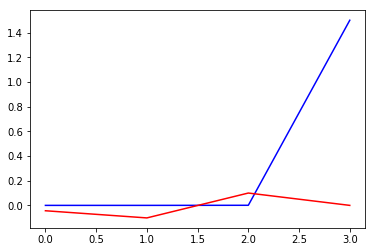

... 0.8351483887119375 1.0575358462172666
... 0.7092060466324062 0.8359318774851293
... 0.6346783733014542 0.7107051298919003
... 0.5876919794017014 0.6360458288495374
... 0.5560157652469171 0.5887018614384429
... 0.533257893199508 0.5566877991566437
... 0.5159858428444706 0.5336909049838918
... 0.50228967782946 0.5162885485574421
... 0.49105960236250723 0.5025555278481849
... 0.48161840778363024 0.49136060810117876
... 0.4735313021966912 0.48200642552925665
... 0.4665052076146875 0.47404167157901894
... 0.46033378797469593 0.467160631766255
... 0.4548662991701194 0.46114769361591607
... 0.44998917150604434 0.45584549578082545
... 0.44561462524227097 0.45113585589580707
... 0.4416733268077341 0.4469278485984503
... 0.43810946902666603 0.4431500475046553
... 0.43487737017439043 0.43974529757712477
... 0.43193906361455076 0.4366670904823021
... 0.42926255588551115 0.43387699406860447
... 0.42682054825225024 0.4313427969467728
... 0.4245894862752577 0.4290371501887116
... 0.42254884509621

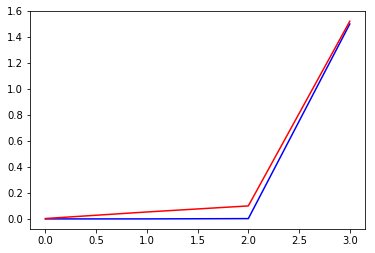

... 0.8320404629504367 1.0516504404663187
... 0.7074645581988671 0.8328348566786112
... 0.6336123012367746 0.7089565391706673
... 0.5869630957040266 0.6349716756809946
... 0.5554581115297709 0.5879698027192888
... 0.53278962246575 0.5561330471769759
... 0.5155662197458021 0.5332309961616845
... 0.5018981247600163 0.5158816200867417
... 0.490685490723376 0.5021798784199599
... 0.48125607809105986 0.49100466387229136
... 0.47317762536510055 0.48166379183840907
... 0.4661583806573128 0.4737086721519816
... 0.45999273012084163 0.4668350674995302
... 0.45453034136326526 0.46082820248874845
... 0.4496578907243836 0.45553121204550157
... 0.4452877516776306 0.4508262208327177
... 0.44135068886197665 0.4466225001063545
... 0.4377909588555795 0.4428487522909699
... 0.4345629210690527 0.43944790752457624
... 0.4316286346565788 0.4363735135223871
... 0.42895612134983374 0.43358717425472587
... 0.42651809026020615 0.4310567006468611
... 0.4242909897453892 0.4287547564973898
... 0.422254294347835 0.

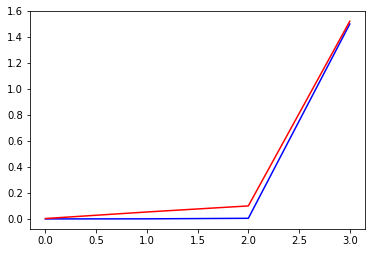

... 0.8275258054246251 1.043562033586508
... 0.7047259708166598 0.8283357417115802
... 0.6317566368423826 0.7062119852456193
... 0.5855541123446845 0.6331100453329281
... 0.5542821820791785 0.5865620434077359
... 0.5317414924554811 0.5549667212622109
... 0.514593402341564 0.5321998115973641
... 0.5009738832662466 0.5149314591431177
... 0.4897957283753276 0.5012824297082922
... 0.48039297748822996 0.49014452474675735
... 0.47233655597133 0.4808321383014607
... 0.46533638557956664 0.4729001299681943
... 0.45918777553570705 0.4660461454647926
... 0.45374093496870105 0.4600564908524027
... 0.4488828800256359 0.454774958765024
... 0.44452621131028835 0.45008409724535325
... 0.44060185330567453 0.4458934639910787
... 0.43705417939317504 0.4421319629528823
... 0.4338376365547898 0.4387426701359812
... 0.4309143507574035 0.435679240950569
... 0.4282523953738338 0.43290336001287466
... 0.42582451988882575 0.4303828993188563
... 0.423607204602441 0.4280905693989409
... 0.42157994967675577 0.4260

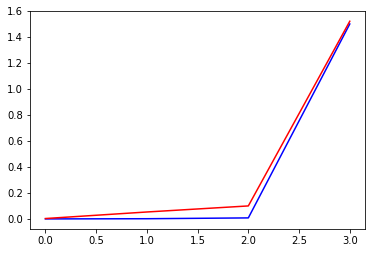

... 0.8213897900838238 1.0330441638726893
... 0.7007887722483945 0.8222191161143279
... 0.6289218596722981 0.7022693987979941
... 0.5832857012807338 0.6302709316453502
... 0.55231704054021 0.5842987632811809
... 0.5299493943409375 0.5530173496579748
... 0.5129088317525067 0.5304326471931351
... 0.4993629305518123 0.513278844932354
... 0.4882400334864465 0.49970842845968066
... 0.4788819426181944 0.4886291104159011
... 0.4708635594573057 0.47936343678822435
... 0.4638969279058129 0.4714705817092331
... 0.45777855757802194 0.46465058101830614
... 0.4523593869764139 0.4586911431716077
... 0.44752691017434965 0.45343693800216506
... 0.44319406303522346 0.44877109758961525
... 0.43929201823921266 0.44460359003850813
... 0.43576534018094343 0.44086362017411435
... 0.4325686268624784 0.4374944916236341
... 0.4296641259756239 0.43445003604825794
... 0.42702001049607247 0.43169207701959966
... 0.42460911249132494 0.42918859777008284
... 0.4224079815994823 0.4269123991469645
... 0.42039617693464

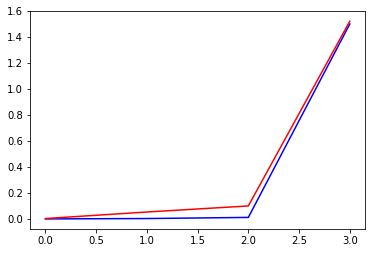

... 0.8134386329310166 1.019903506969861
... 0.6954660933908823 0.8142903356400779
... 0.6249301334801994 0.6969413473055709
... 0.5799887773241613 0.626275991587794
... 0.549401252081685 0.5810103258870967
... 0.5272582964907133 0.5501228641004473
... 0.510362742825695 0.5277737458731763
... 0.4969198160390449 0.5107731964259524
... 0.4858765029167992 0.4973115234396179
... 0.4765840094948204 0.48631553888507667
... 0.46862213047542645 0.4771176725576757
... 0.46170557985416605 0.46928240500215607
... 0.4556324211638391 0.46251276800317986
... 0.4502545682338409 0.45659826892941
... 0.445460175563256 0.4513847318836301
... 0.44116265653541537 0.44675607759893904
... 0.43729354690385347 0.44262284234413796
... 0.4337976971663257 0.4389146574156894
... 0.43062993647288217 0.4355751564706676
... 0.42775270268319854 0.4325584324657912
... 0.4251343274851916 0.4298265196044851
... 0.4227477770603327 0.42734757352562724
... 0.42056971568363255 0.4250945381723756
... 0.41857980153747193 0.42

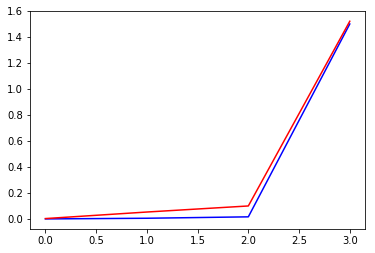

... 0.8035030286415561 1.0039839141345859
... 0.6885889753929288 0.8043791775980162
... 0.6196182638675467 0.6900583080117257
... 0.5755072070090309 0.6209615054871094
... 0.5453853958979837 0.5765399886137347
... 0.5235246028321203 0.5461331131704096
... 0.5068164012031825 0.5240786570144138
... 0.49350980224944085 0.5072748110345124
... 0.4825736759633262 0.4939559086355967
... 0.4733704145673062 0.48307119335973436
... 0.46548574229160733 0.4739648493344216
... 0.45863768654899134 0.4662077727269867
... 0.452626292375079 0.45950669076107753
... 0.447304751641549 0.4536533789194044
... 0.4425621051489267 0.44849514834545495
... 0.4383124193321421 0.44391695561205124
... 0.43448773363233223 0.4398300955710013
... 0.43103329988809386 0.4361647768610122
... 0.4279042745209209 0.43286508536821516
... 0.42506336689643326 0.42988547610600364
... 0.4224791370841172 0.42718827825841693
... 0.42012474569154334 0.4247418914187896
... 0.41797702433622314 0.4225194640340211
... 0.416015776713874

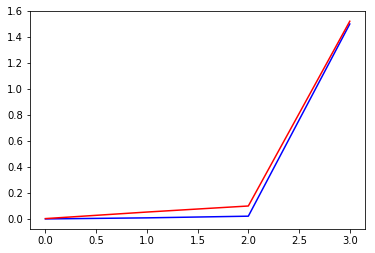

... 0.7914416457292621 0.985170060930603
... 0.6800096138607509 0.7923433511741017
... 0.6128406817243222 0.6814719189899119
... 0.5697005609629968 0.6141813644907171
... 0.5401346259446016 0.570746658707185
... 0.5186185593158906 0.5409124273532678
... 0.5021443869988974 0.5192166483261701
... 0.48901105082144336 0.5026571549144832
... 0.47821264225041904 0.4895185171223027
... 0.46912463949015293 0.4787758391564034
... 0.46133983993739375 0.4697870442128268
... 0.4545803164068868 0.4621306573560268
... 0.4486485929485522 0.45551788670102916
... 0.44339949613818097 0.4497433128603117
... 0.43872322022518007 0.44465611913769737
... 0.4345346918151941 0.4401425852156007
... 0.43076661898178137 0.4361149856571012
... 0.42736478908263675 0.4325042809952552
... 0.4242847968783006 0.4292551500009904
... 0.4214897165492627 0.4263225250846177
... 0.41894841595798676 0.423669126450543
... 0.41663431850351135 0.4212636787177247
... 0.4145244826077449 0.4190796041228647
... 0.41259890966970236 0

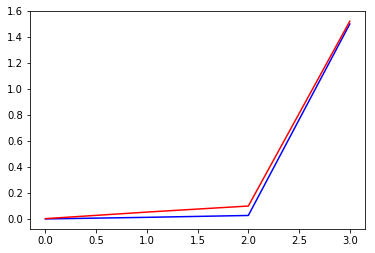

... 0.7771443689128757 0.9633905794522147
... 0.6696044820242991 0.7780717570338774
... 0.6044723651093482 0.6710581100414892
... 0.5624468309389922 0.6058099978892126
... 0.5335312076917341 0.5635076164198544
... 0.5124266414145557 0.5343421636374903
... 0.4962368620265351 0.5130731031579437
... 0.4833167937612158 0.4968091418875385
... 0.4726891363691436 0.48389120570299243
... 0.4637444442230646 0.47332373323774296
... 0.45608382338989656 0.4644804569850886
... 0.44943420334921896 0.4569488315499976
... 0.4436011484570643 0.45044540699863544
... 0.4384415262762293 0.4447681670387115
... 0.43384698969211843 0.439768599758493
... 0.4297335616595399 0.43533463170288345
... 0.42603480611602124 0.43137976619773294
... 0.422697197365374 0.42783591168120333
... 0.41967689309402656 0.42464849710769365
... 0.41693743636064384 0.4217730606970533
... 0.4144480909240057 0.4191728201345587
... 0.41218261847797677 0.41681691457483705
... 0.4101183696626078 0.4146791162728493
... 0.408235600802688

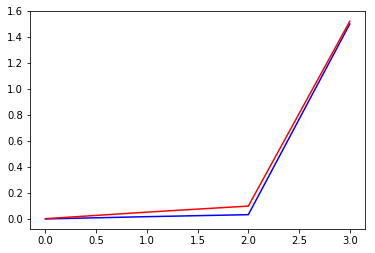

... 0.7605351787886455 0.9386205557692084
... 0.657277232752795 0.761487385877161
... 0.5944116088269574 0.6587200131388898
... 0.5536450287729291 0.595745149474397
... 0.5254769546716312 0.5547211224955696
... 0.5048538516026269 0.526323153352991
... 0.489001753604309 0.5055518320814667
... 0.4763374261710383 0.4896373338634425
... 0.46591555806846463 0.47698286640244925
... 0.45714382932006065 0.4666256649719675
... 0.4496329633121067 0.457957394516797
... 0.4431156247545101 0.45057580727648344
... 0.4374010352510251 0.4442037190419047
... 0.4323485534361521 0.43864316672265136
... 0.4278516297081123 0.43374841701193895
... 0.42382764524369154 0.4294093988567892
... 0.42021122668910577 0.4255411177137513
... 0.41694970180016705 0.42207664455536703
... 0.41399992750297937 0.41896233017819196
... 0.41132602904928706 0.41615445822908725
... 0.4088977616126583 0.41361685920391383
... 0.40668930672547365 0.4113191834347802
... 0.4046783776578548 0.4092356352505542
... 0.4028455470789747 0

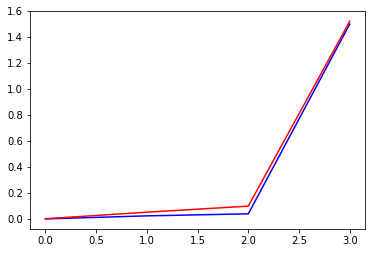

... 0.7415745640600777 0.9108832869930967
... 0.6429612806280988 0.7425497506955854
... 0.5825825505340141 0.6443905534105999
... 0.543217583333966 0.5839104116301841
... 0.515895487057823 0.5443088259081477
... 0.49582585408185204 0.5167779752917233
... 0.48036678620866785 0.49657722575969093
... 0.4680024549056717 0.4810679937341185
... 0.4578228549744097 0.4687213989080042
... 0.44925486640601536 0.4586108646941719
... 0.4419201899885777 0.45014812872976756
... 0.43555815712685964 0.44294265361106155
... 0.429982309249893 0.43672449209232167
... 0.42505498270356273 0.4313004258975486
... 0.4206717925445311 0.4265280076484616
... 0.4167517615722075 0.42229955028441385
... 0.41323080232375103 0.4185318546912175
... 0.4100572749660041 0.4151593841977303
... 0.4071888815641917 0.41212959473450983
... 0.4045904503559419 0.40939966398992694
... 0.40223232937284914 0.40693415765332497
... 0.40008920630102063 0.4047033394920158
... 0.3981392313576621 0.40268193250895074
... 0.39636335821926

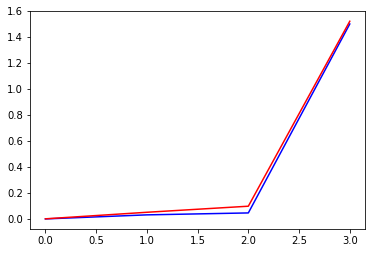

... 0.7202613703117288 0.8802512088424661
... 0.6266219699243954 0.7212567561707437
... 0.5689373648217015 0.6280346262749492
... 0.5311124531131255 0.5702574284122355
... 0.5047342355439481 0.5322178892640994
... 0.48529087472774635 0.5056529770655296
... 0.4702812927587707 0.486096176685777
... 0.45826223796989646 0.47104892205449667
... 0.44836220505836033 0.4590554782423401
... 0.440029335982669 0.44922871670728026
... 0.43289769614372475 0.4410025667045612
... 0.42671425142402325 0.4339996332388612
... 0.4212975595605022 0.4279582074003356
... 0.4165134492463653 0.42269053656592814
... 0.4122600892031646 0.41805799116106646
... 0.4084584438761127 0.41395566907428194
... 0.40504594738370286 0.41030247475368276
... 0.40197218067242213 0.4070345049398584
... 0.399195843971854 0.40410051249239265
... 0.3966825947563792 0.40145872423691803
... 0.39440347960017125 0.39907456843793415
... 0.3923337820070502 0.39691902846836125
... 0.39045216614553047 0.3949674357176122
... 0.388740033552

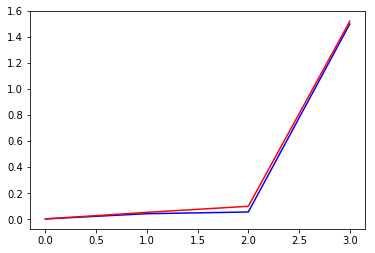

... 0.6966340014206357 0.8468459243759919
... 0.6082582422081039 0.6976459207251952
... 0.5534580423273571 0.6096507741732313
... 0.517304876451204 0.5547676844365547
... 0.491966117399861 0.5184227535565318
... 0.47322129736578655 0.4929199711579727
... 0.45871774011330796 0.4740797003756733
... 0.4470894520208029 0.4595510114766145
... 0.4375064384268144 0.4479560543413079
... 0.4294401138905645 0.4384502155428157
... 0.42253829637005924 0.43049167342615446
... 0.4165565719008525 0.42371759953857185
... 0.41131923169592827 0.4178755357499116
... 0.4066961297198438 0.4127839314728586
... 0.40258839195010304 0.40830852132677453
... 0.39891923556839143 0.404347600967332
... 0.3956278601579029 0.40082249566010963
... 0.3926652618144756 0.3976711834254333
... 0.38999129634650126 0.39484391087240467
... 0.38757257994175903 0.3923001127607804
... 0.38538096579387343 0.3900062100526852
... 0.3833924246833127 0.38793401394742283
... 0.38158621309795193 0.3860595554867763
... 0.379944248335915

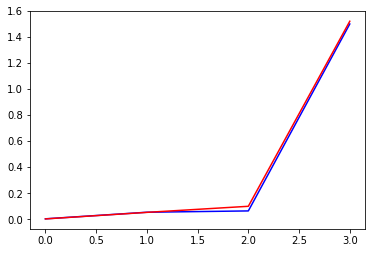

... 0.6707709048456124 0.810837287095006
... 0.5879037281630786 0.6717948818709908
... 0.5361576794120353 0.5892722872303793
... 0.501798688444899 0.5374538048384121
... 0.477590817701738 0.5029264709257739
... 0.4596148929797493 0.4785775381499696
... 0.44567290840326756 0.4605241919755607
... 0.4344802300352864 0.4465694578144257
... 0.4252511424265258 0.43541752476613277
... 0.4174822519474809 0.426269108576608
... 0.4108364898946594 0.4186085917405713
... 0.40507904615720386 0.4120890999810549
... 0.4000406688540263 0.4064684290897116
... 0.39559577778073013 0.4015719676552596
... 0.3916488663529552 0.3972703644884147
... 0.3881257205552592 0.39346552952123215
... 0.3849675527970221 0.39008152900301285
... 0.3821269709873888 0.3870584721209171
... 0.3795651453562755 0.3843482973227531
... 0.37724978110434554 0.3819118068095895
... 0.37515364653327415 0.3797165446856233
... 0.373253491297155 0.3777352582608037
... 0.3715292425296655 0.37594476939206195
... 0.36996340103380776 0.3743

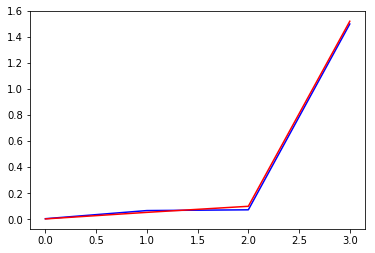

... 0.6427902897888939 0.7724415162295324
... 0.5656272018635015 0.6438211332590222
... 0.517081215064223 0.5669676657841555
... 0.48462714310969185 0.5183603026570611
... 0.46163561720758983 0.4857615435640237
... 0.44449562617580085 0.4626518779932319
... 0.43116867098686334 0.44545226186924325
... 0.4204549179351595 0.43212457367062834
... 0.4116154004475046 0.4214585283954399
... 0.404173704390973 0.41270267436340047
... 0.39780917928290294 0.40536941007620564
... 0.3922975797478028 0.399129137324637
... 0.3874768252069649 0.3937508784575632
... 0.3832264381279272 0.3890676835885233
... 0.3794546876059321 0.3849556577945593
... 0.37609024297612714 0.3813207368344079
... 0.3730765753009972 0.37809004444617134
... 0.37036809933454384 0.3752060678281877
... 0.36792745687535267 0.3726226326691513
... 0.36572357073461986 0.3703020656900638
... 0.36373023114972003 0.36821316237352236
... 0.36192505665586405 0.36632971241633516
... 0.36028872185694705 0.36462941782823305
... 0.35880437739

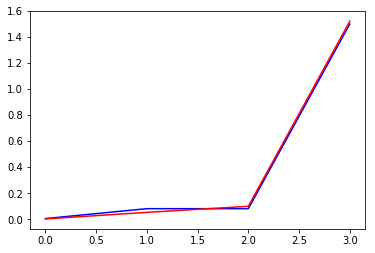

... 0.612849047066362 0.7319183479759193
... 0.5415323516699244 0.6138809616972494
... 0.4963055651463691 0.5428403986815727
... 0.46585319115534546 0.49756372343704763
... 0.4441557189485722 0.46699021863444157
... 0.42791399296565313 0.4451971607422731
... 0.4152523309045268 0.42891310353544276
... 0.4050584075506583 0.4162621595657
... 0.39664212299352897 0.40612231644377844
... 0.38955565961253147 0.3977920941527759
... 0.3834960052658875 0.39081353625511867
... 0.3782503960678921 0.3848755475899631
... 0.37366461231031134 0.37975929767729016
... 0.36962380047072685 0.3753061897804587
... 0.36604040275651895 0.3713983075215513
... 0.3628462781367685 0.3679460101522637
... 0.35998739542376346 0.36487978496376966
... 0.35742016555739603 0.3621447357534655
... 0.35510885413874554 0.35969676410089524
... 0.3530237258936056 0.3574998726796857
... 0.35113969604104583 0.3555242317927256
... 0.3494353386533253 0.35374477567990625
... 0.3478921496415558 0.35214017226508154
... 0.34649399314

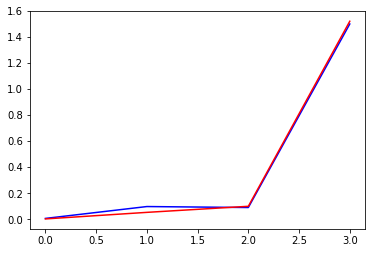

... 0.5811408608599042 0.6895672529642375
... 0.5157568397437118 0.5821675737842055
... 0.4739391194978949 0.5170280290749177
... 0.4455691774063883 0.47517215222354814
... 0.4252340380276569 0.4467042027226808
... 0.4099468554146815 0.4262953405351151
... 0.3979964804767072 0.410982358337725
... 0.3883600135073396 0.3990533982201771
... 0.38039793934721616 0.38947666730221
... 0.37369244606523133 0.38160238375159716
... 0.3679592669719283 0.37500364506147077
... 0.3629979710696082 0.36938896284187034
... 0.3586628483652074 0.36455250110247234
... 0.35484516326308224 0.3603446612460859
... 0.3514619087208997 0.3566539960021646
... 0.34844842452801794 0.3533956629188316
... 0.34575340435900614 0.3505038016424303
... 0.34333543489629864 0.3479263576607119
... 0.3411605496268439 0.3456214862632929
... 0.3392004726016608 0.343555008642147
... 0.33743134116451795 0.34169858598443664
... 0.3358327664711816 0.34002839300438553
... 0.3343871351113335 0.33852414398318686
... 0.33307908443711637

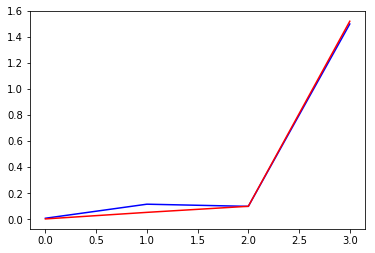

... 0.5478935247132561 0.6457227764883088
... 0.4884706413285143 0.548908424049885
... 0.4501205842894392 0.48970049862592135
... 0.4238959370729244 0.45132406501096045
... 0.40498043299700603 0.4250237744992141
... 0.3906967515918944 0.4060554104727227
... 0.37949836281292165 0.3917614547978256
... 0.370452873146409 0.3805942497437246
... 0.36297262920302387 0.37161332320009555
... 0.3566709918853302 0.3642218639260093
... 0.3512834071819531 0.35802517787823285
... 0.3466225424366191 0.35275233713497317
... 0.34255178991331253 0.3482112537487658
... 0.3389689866938117 0.3442619101422652
... 0.33579602545702797 0.34079977534101763
... 0.3329719961549153 0.33774514832796293
... 0.3304485272709829 0.3350360859541217
... 0.32818654697313215 0.3326235818565245
... 0.32615398938857826 0.3304682080316732
... 0.3243241458643687 0.3285377347417395
... 0.3226744650364067 0.3268054202249537
... 0.32118566986748176 0.32524876732728886
... 0.3198411010938542 0.323848610120043
... 0.318626223840512

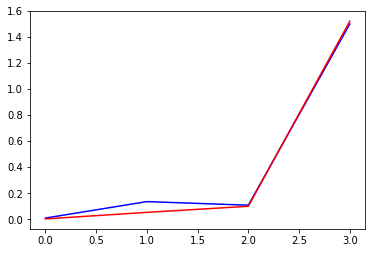

... 0.5133654964929529 0.6007490832199074
... 0.45987367485391656 0.5143617789294721
... 0.42501716988005084 0.46105778096423045
... 0.4009812862922077 0.42618652457275236
... 0.38353037210997815 0.402096290490203
... 0.3702906731751382 0.38461209097473525
... 0.359878727128001 0.3713764138244946
... 0.3514528610939845 0.36100433862064196
... 0.3444780856512109 0.35264693920596113
... 0.3385998293775429 0.3457611595642234
... 0.3335740535098784 0.339985384336569
... 0.3292271838531391 0.335070025290441
... 0.3254322363229026 0.33083738320009237
... 0.3220940250050013 0.3271575276604109
... 0.31913965407697414 0.32393323672508767
... 0.31651220466581503 0.32109025389191564
... 0.3141664278686322 0.3185707877285503
... 0.3120657414050859 0.3163290629485575
... 0.310180098427309 0.3143282126261403
... 0.3084844536788199 0.31253807163744374
... 0.30695764630568384 0.3109335891481834
... 0.3055815773499546 0.3094936735764665
... 0.3043405978956177 0.30820034360340637
... 0.3032210490810104 

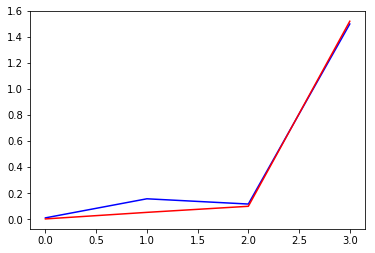

... 0.47784174887923564 0.5550338114671377
... 0.43019275396647266 0.478812572824642
... 0.3988221427180205 0.4313268353349177
... 0.37699791912691866 0.39995273891230765
... 0.3610430432621273 0.37809409564140467
... 0.3488783175876384 0.36212395973328965
... 0.33928018349620676 0.3499761259254356
... 0.33149702320552676 0.34042533715649714
... 0.32504681350913456 0.3327135482439799
... 0.3196076477264569 0.326351730489873
... 0.3149566182950814 0.3210119081971685
... 0.31093444661949077 0.31646641612618404
... 0.3074242088144656 0.3125524543649368
... 0.3043380394090836 0.30915059574622267
... 0.301608520713919 0.30617125542221746
... 0.2991829316622461 0.30354587667055155
... 0.2970193069879697 0.3012210180415532
... 0.29508368075622454 0.29915429018772605
... 0.29334812633391044 0.2973115094895181
... 0.2917893438378119 0.2956646732082149
... 0.2903876303667744 0.2941905008165468
... 0.2891261213598023 0.292869371739024
... 0.2879902259265507 0.2916845439997447
... 0.28696720207673

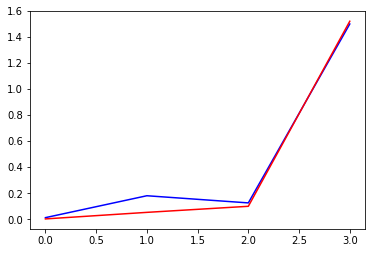

... 0.4416289925987233 0.5089813627921425
... 0.3996779121675832 0.4425676332505677
... 0.3717517779846925 0.40075793098885637
... 0.3521407400083715 0.3728390187662115
... 0.33769893207380075 0.35321186719953895
... 0.3266298362283453 0.33877104707305233
... 0.3178650765981124 0.3277301211760749
... 0.31074154792959185 0.3190188640458842
... 0.3048299798307845 0.31196855920183253
... 0.29984140974282386 0.3061439497406957
... 0.295574472125237 0.30125093222769217
... 0.2918845827386722 0.29708413399977457
... 0.2886652174311344 0.29349602014390586
... 0.2858361043508949 0.290377980991127
... 0.28333551828085995 0.28764832316070255
... 0.28111510275962637 0.2852443902556917
... 0.27913630622248087 0.28311724755988804
... 0.2773678813682722 0.2812280144183413
... 0.2757841032388319 0.2795452874692951
... 0.27436348315984493 0.27804330389593496
... 0.27308783021875455 0.2767006163982971
... 0.2719415592743952 0.27549912724641656
... 0.2709111754989866 0.2744233771469531
... 0.26998488630

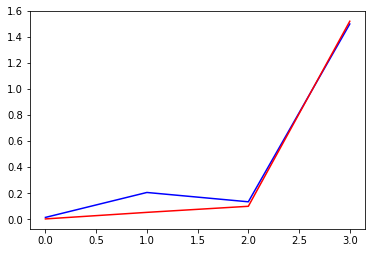

... 0.40505036841397835 0.46300577031671675
... 0.3685981692264261 0.40595037097396164
... 0.3440417671458592 0.3696204114083467
... 0.32662367693262984 0.3450811880991223
... 0.3136969078428689 0.3276634368083265
... 0.3037331147567351 0.3147519358704935
... 0.2958129117011642 0.3048258672022454
... 0.2893593062516156 0.2969639305070583
... 0.2839950460879093 0.29058431843459454
... 0.2794640607522667 0.28530475791282534
... 0.27558671791294076 0.28086490927152946
... 0.2722333753639596 0.2770818346687308
... 0.26930814092721195 0.2738234729823668
... 0.2667385312640342 0.2709922347612601
... 0.264468669522185 0.2685144911448718
... 0.2624546861149239 0.26633362603311095
... 0.26066153868607833 0.2644053221973066
... 0.25906077356981333 0.26269429487798707
... 0.2576289270373135 0.2611719899789516
... 0.25634636958981455 0.25981493981549614
... 0.2551964615386014 0.2586035751104355
... 0.25416492974806354 0.25752135787635
... 0.25323940289821495 0.2565541423419224
... 0.25240906120214

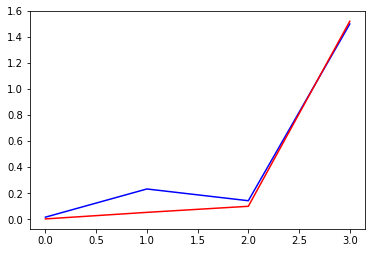

... 0.41244773341849134 0.4728002330033589
... 0.3745613838311703 0.4134133194257232
... 0.34898288896733615 0.3756253474174103
... 0.33074298175540484 0.35004172233446573
... 0.31710057943406755 0.33178591205760355
... 0.30648711780331334 0.31814922023656456
... 0.2979667953265415 0.30756976099212796
... 0.29095613049749214 0.2991085767376368
... 0.2850751093555867 0.2921761735567439
... 0.2800660045561563 0.28638651219106803
... 0.27574762911149964 0.28147680928254143
... 0.2719885869969409 0.2772619804805677
... 0.268691010915336 0.27360777750169085
... 0.26578029168843564 0.27041432490975736
... 0.26319836193650203 0.26760564893251226
... 0.2608991702960627 0.26512279132461314
... 0.2588455552409989 0.26291915036228736
... 0.25700704200539076 0.260957254493319
... 0.2553582646122714 0.2592064858870212
... 0.2538778201919633 0.25764144964328944
... 0.252547427157796 0.256240790550305
... 0.2513512996725365 0.25498632479835986
... 0.25027567761876834 0.25386239594817284
... 0.2493084

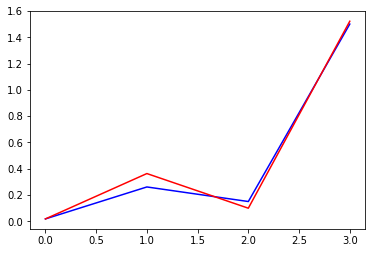

... 0.3744662688088028 0.42574435742116784
... 0.34192600019277647 0.37537624065567676
... 0.31967308686274665 0.3429211946334478
... 0.3036335855481212 0.3206752098753673
... 0.2915371631230955 0.30463653782011835
... 0.2820695695350357 0.2925595471198528
... 0.27443719277738754 0.2831345795050257
... 0.2681393687020692 0.27556502313625536
... 0.2628465545538905 0.26934510185926147
... 0.258333245112132 0.26414026229212295
... 0.2544397581387295 0.25972083778147514
... 0.25104963334086833 0.25592396099236453
... 0.2480757394332976 0.252630855938395
... 0.24545141230997872 0.24975277338974908
... 0.24312461166752314 0.2472219611435483
... 0.2410539577017656 0.24498567965583698
... 0.2392059800685594 0.24300212859916345
... 0.2375531722766992 0.24123761321969422
... 0.2360725945239475 0.23966453832865728
... 0.2347448573018698 0.23825996771441266
... 0.23355337336360288 0.23700457690574467
... 0.2324838010588883 0.23588188343989347
... 0.23152362542024135 0.23487767505257046
... 0.23066

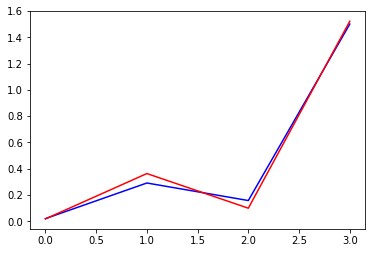

... 0.33706291398853955 0.3799145159341282
... 0.309542098971645 0.33791231066664795
... 0.2904570394535446 0.31046612909068727
... 0.2765409854930255 0.2913988163145114
... 0.2659519364046462 0.27749799218362536
... 0.2576096726797493 0.26693977185644624
... 0.25085315143629044 0.2586468162709087
... 0.24526000952943797 0.25195530830700225
... 0.24054908188864488 0.24643862707893785
... 0.23652612973085577 0.24181153293811164
... 0.23305254694838315 0.23787644260555518
... 0.2300266202590601 0.234492211791023
... 0.2273718724559039 0.23155529700457056
... 0.22502954880784487 0.22898795495889276
... 0.22295361976181557 0.22673059125455158
... 0.22110736859039173 0.22473664848186667
... 0.21946101076319174 0.22296910477405568
... 0.21799000398265048 0.2213980265527133
... 0.21667383117188158 0.21999882994331127
... 0.2154951131445228 0.21875102886512832
... 0.21443895428133075 0.21763732295279048
... 0.2134924546823881 0.2166429258494221
... 0.2126443423188352 0.21575506525136137
... 0.

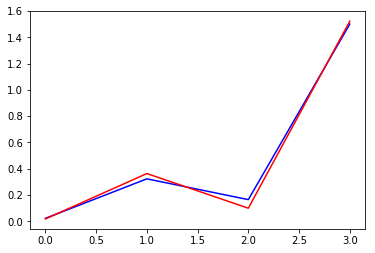

... 0.3005729221968678 0.3356985860825961
... 0.2777088063215697 0.301357591253867
... 0.261607730951469 0.27855990600932695
... 0.24971876083712627 0.2624860237499149
... 0.24058373999443303 0.25062427580739466
... 0.23333483564713042 0.24152912815115954
... 0.22743303673306245 0.23433428205839563
... 0.22252913327605375 0.22849823720977014
... 0.2183878016765163 0.22366832561958921
... 0.21484479889748587 0.21960599997509256
... 0.2117819392607859 0.2161444071233086
... 0.20911190210128838 0.21316340119370195
... 0.20676866006541877 0.21057426318057487
... 0.20470124074410537 0.2083100114162435
... 0.20286953989577491 0.20631905297900252
... 0.20124144239152236 0.20456090611540492
... 0.19979080292072024 0.20300325097875657
... 0.19849600673946474 0.201619858011572
... 0.1973389299288052 0.2003891106032787
... 0.1963041793034094 0.1992929380628817
... 0.19537853055115428 0.1983160362155383
... 0.19455050830409154 0.19744529200711347
... 0.19381006868454045 0.1966693541741282
... 0.19

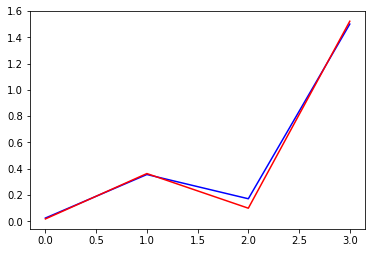

... 0.265318273001652 0.29345836514473594
... 0.24671856758042496 0.26603496284380423
... 0.23339469585982575 0.24749564977903946
... 0.22341865637763444 0.2342069447159695
... 0.21567042170258877 0.22426768484343337
... 0.20947194586546306 0.21656603504242258
... 0.20439498814278262 0.21042448467778382
... 0.20015780370450403 0.20541263705761204
... 0.1965679744660659 0.20124602725832844
... 0.19348968754150975 0.19772977429861388
... 0.1908243043055145 0.1947261037224754
... 0.1884983810954682 0.19213492356899697
... 0.18645601607459966 0.18988176860445635
... 0.18465380189085226 0.18791005337144817
... 0.18305740573130982 0.186175939263945
... 0.1816392000358469 0.1846448448820277
... 0.1803765912235113 0.18328902319547133
... 0.17925082316914168 0.18208585052238072
... 0.178246109646748 0.18101660115607215
... 0.17734899805745125 0.18006555919564635
... 0.1765478976304713 0.179219367722771
... 0.17583272567236882 0.17846654683534346
... 0.1751946392192634 0.17779713286218582
... 0.

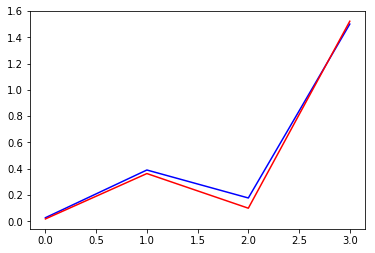

... 0.23160182973535112 0.253523296867821
... 0.21685174290102555 0.2322482609612504
... 0.20607902322685806 0.21755443707327957
... 0.19788593433220675 0.20682331640236706
... 0.19144447222302519 0.1986741525352407
... 0.18624323354172123 0.19228372099952168
... 0.18195296524690166 0.18714047916007048
... 0.17835326041791286 0.18291338776589017
... 0.17529132182430043 0.17937998987926035
... 0.17265793271368846 0.17638569303295584
... 0.1703729247517926 0.17381987999731327
... 0.16837606257804086 0.1716013639852432
... 0.16662113036333953 0.16966920931649596
... 0.16507198154616962 0.16797674597683412
... 0.16369983463837734 0.1664875554633748
... 0.16248138468909293 0.1651727152384416
... 0.16139746269226765 0.16400887103699638
... 0.16043207087477732 0.16297686735514275
... 0.1595716801116057 0.16206076182872056
... 0.15880471251005196 0.16124710776081402
... 0.1581211561494694 0.16052442623508786
... 0.15751227495130543 0.1598828135715836
... 0.15697038755074377 0.15931364618621222

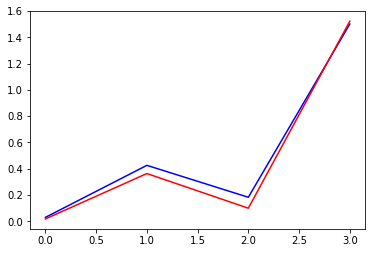

... 0.19970190227260531 0.21618490760226383
... 0.18837144575626252 0.20027681634397487
... 0.17990852045718397 0.18900012183885911
... 0.17335484140909954 0.18058365258360848
... 0.16812875108913647 0.1740787029391505
... 0.16386221027944586 0.1689059339550445
... 0.16031285836041573 0.16469678762989087
... 0.15731516820046215 0.1612075111074738
... 0.1547523880178611 0.15827112482233857
... 0.15253982701942984 0.15576965492568073
... 0.15061452587487034 0.15361748380719356
... 0.14892864738186373 0.15175099709351034
... 0.14744511463195517 0.15012192360802248
... 0.1461346557971056 0.14869292101621723
... 0.14497375812094052 0.1474345754234213
... 0.14394322613940194 0.14632331960514486
... 0.14302715071052335 0.145339964211919
... 0.1422121624581864 0.14446864697499415
... 0.14148688494498265 0.1436960718917851
... 0.1408415296936563 0.1430109522980209
... 0.1402675928837491 0.14240359882513895
... 0.13975762551270246 0.14186561121734184
... 0.1393050570345747 0.14138964516753744
..

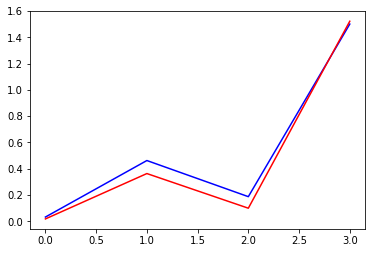

... 0.1698673428723715 0.18169207834635995
... 0.16151874679653852 0.17037052703109867
... 0.15511315134430848 0.162074524949105
... 0.15004429799257432 0.1557186681805284
... 0.14593240295127485 0.1507011239867281
... 0.14252977712475662 0.14664283780796064
... 0.1396687537895433 0.14329548390466632
... 0.13723200978159394 0.14049040917714242
... 0.1351350361553387 0.13810935991238946
... 0.13331539904187625 0.13606708419208402
... 0.1317259252899938 0.13430060916154005
... 0.13033023914555544 0.1327624003464945
... 0.12909975802766388 0.13141586105113562
... 0.12801162408368216 0.1302322926588742
... 0.12704725336129502 0.12918879672129788
... 0.12619130244620758 0.1282668012497584
... 0.12543092273154693 0.12745101027531155
... 0.12475521588159795 0.12672864569895165
... 0.1241548317234821 0.1260888938937778
... 0.12362166795362256 0.12552249737081064
... 0.1231486432377896 0.12502145017386246
... 0.12272952362456248 0.12457876803909909
... 0.12235878797943146 0.12418831283996176
..

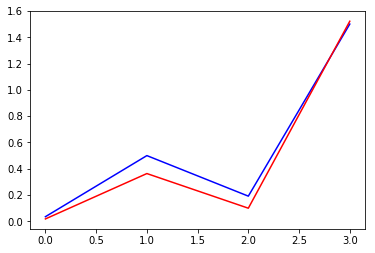

... 0.14231328959103845 0.15024725786509513
... 0.13650835684335222 0.14274557756660894
... 0.13190085673940374 0.1369931026381377
... 0.12815391150091449 0.1324370851773598
... 0.1250470603144826 0.128741962332429
... 0.12243059314140554 0.12568719203011752
... 0.12019944069900398 0.12312253452130559
... 0.11827770568467229 0.12094233983926783
... 0.11660915978969723 0.11907022460501532
... 0.11515119961085796 0.11744960465309896
... 0.1138708803716738 0.11603764269019763
... 0.1127422422377697 0.11480125962416111
... 0.11174446715862785 0.11371443689975003
... 0.11086058459220738 0.11275635242876526
... 0.11007654857865935 0.11191006965677591
... 0.10938057083832477 0.11116160201898014
... 0.10876263304892528 0.11049923678363047
... 0.10821412603280864 0.1099130406971792
... 0.10772757972411728 0.10939449450795677
... 0.10729645863004435 0.10893621971160106
... 0.10691500492007383 0.10853177182890963
... 0.10657811642442709 0.10817548205004837
... 0.10628125043112277 0.10786233430770

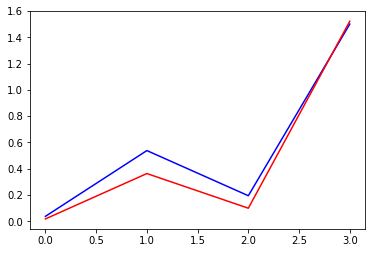

... 0.18147588570436451 0.18789860508792114
... 0.1766256867849952 0.1818585794050841
... 0.17269244641179793 0.17705904571390757
... 0.16943474754827187 0.1731760635697465
... 0.1666911970858507 0.1699687135421917
... 0.16434991300217575 0.16727531790835387
... 0.16233080957845536 0.16498350226354627
... 0.16057493266539855 0.16301271262092434
... 0.1590378030938461 0.1613036276699729
... 0.15768511908536095 0.15981151320142103
... 0.1564898973286183 0.15850191063209496
... 0.1554305219774108 0.15734775747674484
... 0.15448938462144998 0.15632741644837178
... 0.15365191926375685 0.15542329876847494
... 0.15290590715606378 0.15462088614406155
... 0.15224096926971734 0.15390802587469354
... 0.15164819109013278 0.1532744162465056
... 0.15111984181439247 0.15271122628828432
... 0.15064916156664834 0.15221081144846302
... 0.15023019805962168 0.15176649839606665
... 0.14985767951131512 0.15137242006162768
... 0.14952691437850799 0.15102338749632685
... 0.1492337111105276 0.1507147889432115


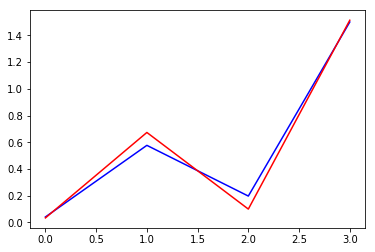

... 0.15833113685990355 0.1620415757258952
... 0.15532211580013952 0.15864542634783557
... 0.15275177197995016 0.1556884509098254
... 0.15053262621057956 0.15316847375261866
... 0.14860059015556054 0.1509979098289678
... 0.1469074179502716 0.1491125270595201
... 0.14541591377706242 0.14746396519277624
... 0.14409678848394028 0.14601496196620267
... 0.14292653803668018 0.14473620823764963
... 0.1418859763046582 0.14360421801141174
... 0.1409591992700844 0.14259985157706362
... 0.14013284084273733 0.14170727108512982
... 0.13939552986125975 0.14091318940109138
... 0.13873748824577753 0.14020632181458928
... 0.13815022956159176 0.13957698032438653
... 0.1376263298586235 0.1390167694622582
... 0.13715925108420846 0.13851835524724218
..........................
[0.04371061 0.61639993 0.19906034 1.50000673]
[0.03380772 0.67343273 0.1        1.51338862]


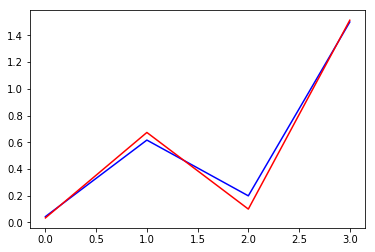

... 0.13787905611768797 0.13954577372405205
... 0.13631126898772503 0.13812870364178573
... 0.13485066418483238 0.1366145229368167
... 0.13350045319812368 0.1352030806905407
... 0.13225998593732965 0.13389820416603973
... 0.13112595599391935 0.13269971688621662
... 0.1300933503912634 0.13160468722284474
... 0.12915615593869553 0.1306084059046633
... 0.1283078639390927 0.12970511097695725
... 0.12754181894500305 0.12888850543179986
... 0.12685145171275153 0.12815211517709205
... 0.12623042850016405 0.1274895286811101
..........................
[0.04652654 0.65611229 0.19994995 1.50000756]
[0.03380772 0.67343273 0.1        1.51338862]


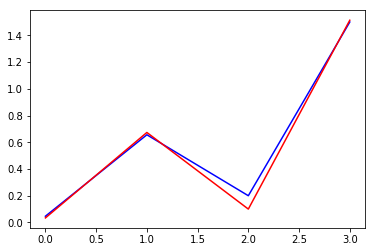

... 0.12017592182518387 0.120414799440044
... 0.11967408644681275 0.12036551783220185
..........................
[0.04935502 0.69600213 0.20003995 1.50000843]
[0.03380772 0.67343273 0.1        1.51338862]


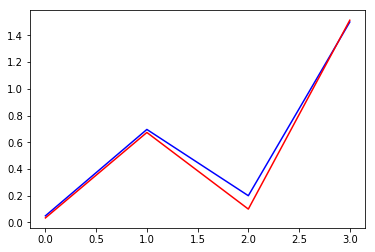

..........................
[0.05218473 0.73590992 0.19932964 1.50000934]
[0.03380772 0.67343273 0.1        1.51338862]


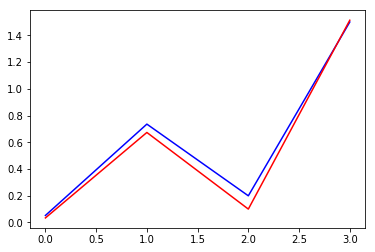

..........................
[0.05500436 0.77567601 0.19782469 1.50001028]
[0.03380772 0.67343273 0.1        1.51338862]


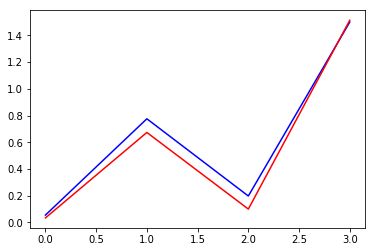

..........................
[0.05780267 0.81514187 0.19553714 1.50001124]
[0.03380772 0.67343273 0.1        1.51338862]


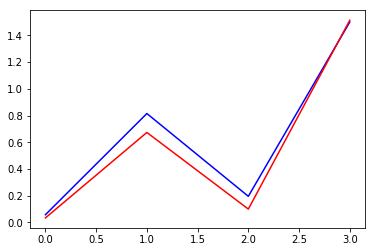

..........................
[0.06056858 0.85415136 0.19248529 1.50001212]
[0.04767961 0.9148053  0.1        1.47079052]


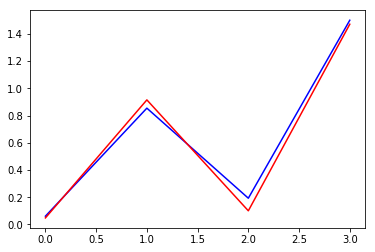

... 0.15689782651837436 0.15692814731817137
..........................
[0.06329129 0.89255202 0.18869357 1.50001292]
[0.04767961 0.9148053  0.1        1.47079052]


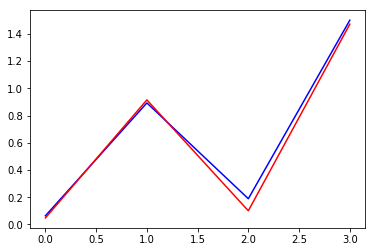

... 0.15437638061147113 0.15523379503893417
... 0.15428058665331254 0.1543344595324871
..........................
[0.06596034 0.93019623 0.18419229 1.50001363]
[0.04767961 0.9148053  0.1        1.47079052]


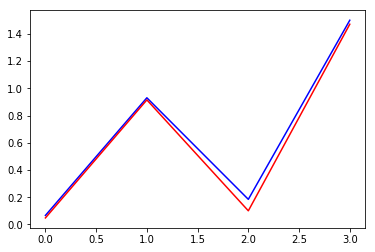

... 0.1539225116113485 0.15575953360718575
... 0.15328906607456233 0.15386502556654366
..........................
[0.06856569 0.96694244 0.17901747 1.50001427]
[0.04767961 0.9148053  0.1        1.47079052]


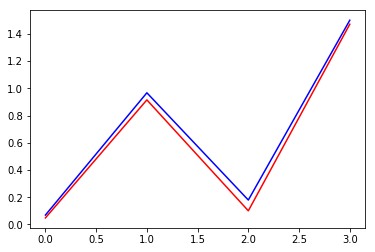

... 0.1553224521818965 0.1582299271817815
... 0.15406918530384123 0.15525608797760787
..........................
[0.07109782 1.00265628 0.17321052 1.50001482]
[0.04767961 0.9148053  0.1        1.47079052]


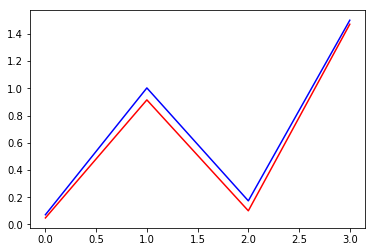

... 0.20462695059924127 0.20852022791375885
... 0.20275577249642676 0.20455760393338293
..........................
[0.07354779 1.03721164 0.16681788 1.50001498]
[0.05893979 1.02702491 0.1        1.2991342 ]


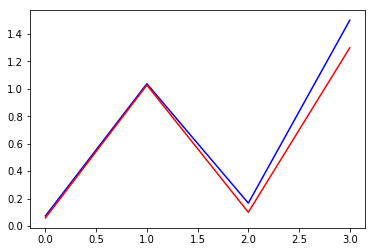

... 0.20894892560591297 0.21391201761712159
... 0.20641090860896966 0.20888274126003595
... 0.20525118763840397 0.20638758275478103
..........................
[0.07590734 1.07049168 0.1598907  1.50001477]
[0.05893979 1.02702491 0.1        1.2991342 ]


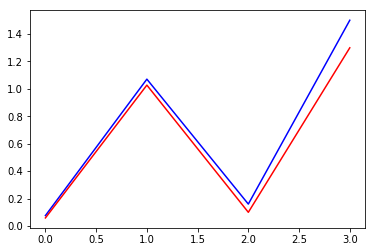

... 0.24070577901061496 0.24656731207754434
... 0.2375702069669535 0.2406470190613438
... 0.23597012281446994 0.23755076663793262
..........................
[0.07816891 1.10238975 0.15248439 1.50001273]
[0.07738386 1.07162785 0.1        0.37990741]


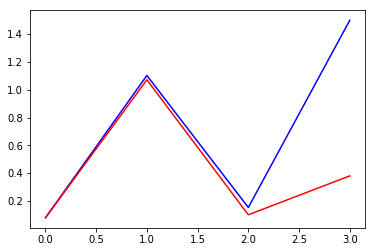

... 0.247682746725977 0.25440554669106064
... 0.24396841399726904 0.24763697614814661
... 0.24193104086213213 0.24395837972544923
..........................
[0.08032579 1.13281026 0.14465821 1.50000877]
[0.08641374 1.07523353 0.1        0.1392161 ]


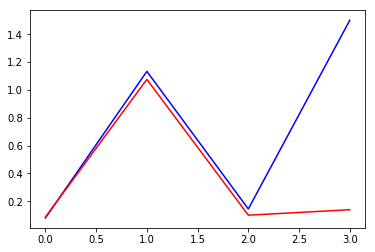

... 0.2546263382189475 0.2621345703153485
... 0.2503682012250868 0.25459780111719477
... 0.2479030011305771 0.25037213524412005
..........................
[0.08237208 1.16166944 0.13647476 1.50000318]
[0.08641374 1.07523353 0.1        0.1392161 ]


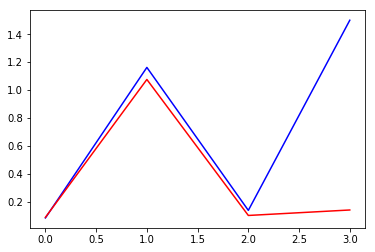

... 0.262861349933788 0.2709625929329946
... 0.258165328555057 0.2628531862029609
... 0.2553281370788078 0.2581865884426256
... 0.2534998509899922 0.2553480755358848
..........................
[0.08430276 1.18889603 0.12799952 1.49999617]
[0.09562104 1.07652368 0.1        0.03713475]


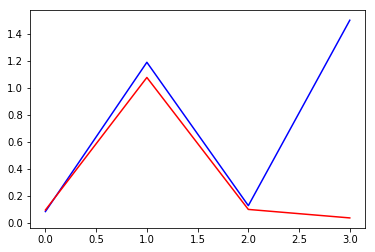

... 0.2704585917214958 0.2790502380927287
... 0.2653823303079732 0.2704736950880856
... 0.2622035009486724 0.26542445968519285
... 0.2600851907967081 0.26224510031844445
..........................
[0.08611372 1.2144318  0.11930027 1.49998806]
[0.09562104 1.07652368 0.1        0.03713475]


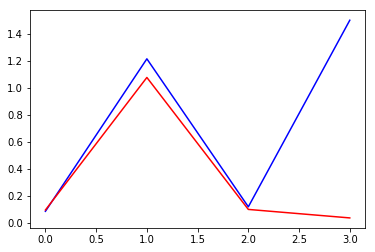

... 0.2780957722634756 0.28701815750813475
... 0.27273398968827756 0.27813614233506734
... 0.2692703821016787 0.2727996165265304
... 0.26689694604256686 0.2693371493265855
..........................
[0.0878018  1.23823206 0.11044663 1.49997917]
[0.09562104 1.07652368 0.1        0.03713475]


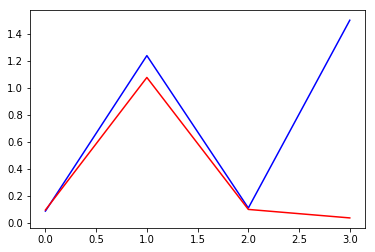

... 0.2855979635018927 0.2946911685118855
... 0.28004908900246706 0.28566491422099344
... 0.2763635711707546 0.2801402532148824
... 0.27377614286355795 0.2764583681355342
..........................
[0.08936479 1.26026602 0.10150941 1.4999698 ]
[0.09562104 1.07652368 0.1        0.03713475]


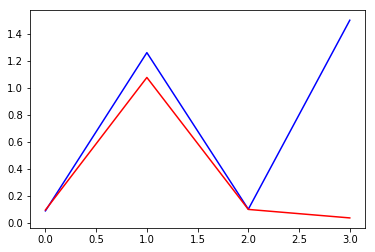

... 0.292812952914315 0.3019224443775962
... 0.28717530665438457 0.29290715154364955
... 0.28333404780943805 0.2872934692158188
... 0.28057804141677717 0.28345907714421525
... 0.278509469131034 0.2807063195515952
..........................
[0.0908015  1.280517   0.09256012 1.49996022]
[0.09562104 1.07652368 0.1        0.03713475]


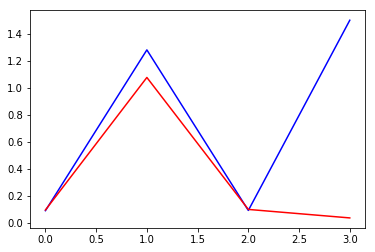

... 0.29961280052033296 0.3085942543941116
... 0.29398115573646677 0.29973432136346584
... 0.2900510511310835 0.2941272193578499
... 0.28717422949895155 0.290207856909589
... 0.28498058963673295 0.2873391220769782
..........................
[0.09211173 1.2989826  0.08367035 1.49995068]
[0.09562104 1.07652368 0.1        0.03713475]


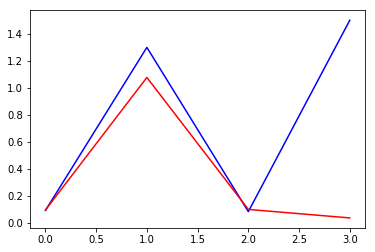

... 0.30685892918433794 0.3155267073509825
... 0.301356997650285 0.30700653537347067
... 0.2974273908149519 0.3015304292540019
... 0.2944952309029591 0.2976159411664687
... 0.2922252128689802 0.29469702548328697
..........................
[0.09329627 1.31567469 0.07491121 1.49994139]
[0.10506119 1.0768744  0.1        0.        ]


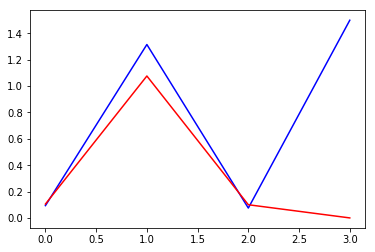

... 0.31253197460255233 0.3208295899393648
... 0.30720327389218927 0.31270547084853456
... 0.3033116830727983 0.30740480273660714
... 0.3003542809537082 0.30353311974632147
... 0.29803116004072777 0.3005942904048615
..........................
[0.09435695 1.33061934 0.06635278 1.49993253]
[0.10506119 1.0768744  0.1        0.        ]


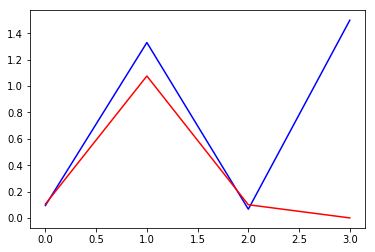

... 0.317559083126711 0.32539304097722094
... 0.3124716510635774 0.3177572015116964
... 0.3086737477864133 0.31270073281974686
... 0.30573519253458215 0.3089277872015882
... 0.30339339123959963 0.3060131683284988
..........................
[0.09529657 1.34385659 0.05806353 1.49992426]
[0.10506119 1.0768744  0.1        0.        ]


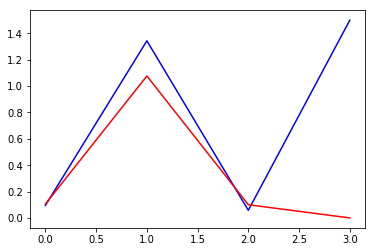

... 0.32191159631463356 0.329208847496395
... 0.3171210520473242 0.3221327866166552
... 0.31346532575576186 0.31737675886086514
... 0.3105854989874116 0.3137511620988881
... 0.30825697112594513 0.310900535889464
..........................
[0.09611889 1.35544015 0.05010978 1.4999167 ]
[0.10506119 1.0768744  0.1        0.        ]


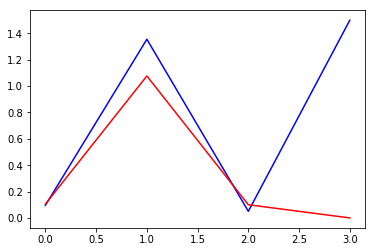

... 0.3255833171895077 0.33229168217378674
... 0.32113193313544397 0.3258258337809478
... 0.3176584754590707 0.32141301283638607
... 0.31487188053909676 0.31797484140144466
..........................
[0.09682865 1.36543694 0.04255514 1.49990993]
[0.10506119 1.0768744  0.1        0.        ]


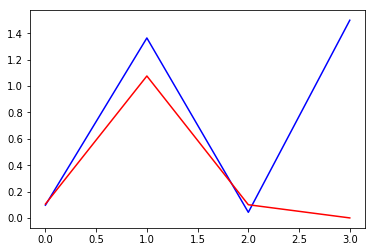

... 0.32858862676098066 0.3346765192941707
... 0.32450488184649573 0.3288506133060654
... 0.3212445024404284 0.32480982007148856
... 0.3185793267749972 0.3215897370250192
..........................
[0.09743146 1.37392659 0.03546007 1.49990401]
[0.10506119 1.0768744  0.1        0.        ]


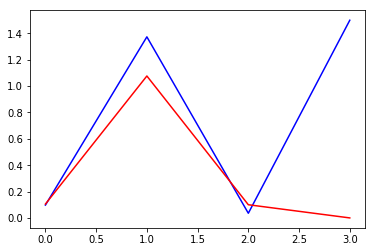

... 0.33096028794439786 0.3364158640630395
... 0.32725885219171413 0.3312398571610321
... 0.324232517834056 0.3275859357357383
... 0.32170993601604325 0.32460463950792784
..........................
[0.09793381 1.38100079 0.02888131 1.49989896]
[0.10506119 1.0768744  0.1        0.        ]


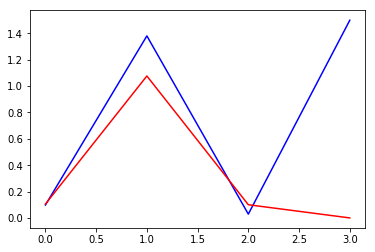

... 0.3327470378545467 0.3375769151373289
... 0.32942912369424276 0.33304234388359155
... 0.3266477009917333 0.32977650347698445
..........................
[0.09834299 1.38676254 0.0228715  1.49989476]
[0.10506119 1.0768744  0.1        0.        ]


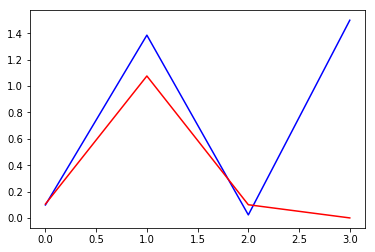

... 0.3340110717495722 0.3382387764261416
... 0.3310650756498076 0.33432037303091655
..........................
[0.09866704 1.39132535 0.01747872 1.49989139]
[0.10506119 1.0768744  0.1        0.        ]


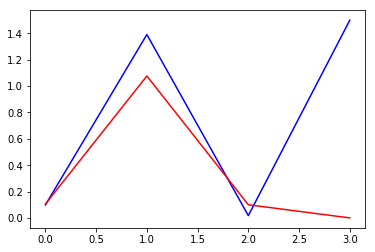

... 0.3348255205672235 0.3384898263591974
... 0.3322278700509381 0.33514723154396214
..........................
[0.0989147  1.39481231 0.01274612 1.49988878]
[0.10506119 1.0768744  0.1        0.        ]


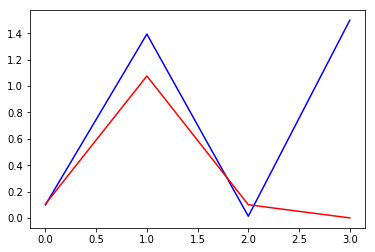

... 0.33527201912284055 0.3384253412457341
... 0.332988135260464 0.335604749567684
..........................
[0.09909531 1.39735513 0.00871154 1.49988687]
[0.10506119 1.0768744  0.1        0.        ]


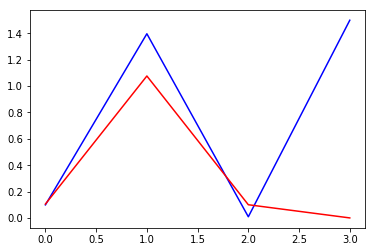

... 0.3354384538362127 0.338145454490804
... 0.33342373800126063 0.3357810351014689
..........................
[0.09921875 1.39909306 0.00540727 1.49988555]
[0.10506119 1.0768744  0.1        0.        ]


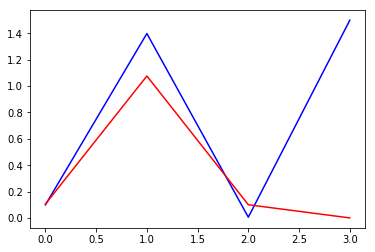

... 0.33541696764125967 0.3377535158462929
... 0.33361772372005 0.33576846565783697
..........................
[0.09929537 1.40017179 0.00285974 1.49988473]
[0.10506119 1.0768744  0.1        0.        ]


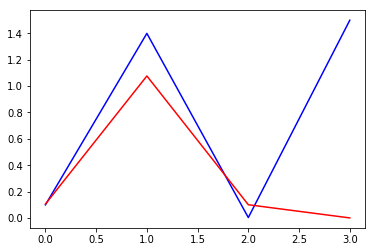

... 0.3353022859252506 0.3373548951863745
... 0.3336564951731741 0.3356620012991251
..........................
[0.0993359  1.4007423  0.00108933 1.49988429]
[0.10506119 1.0768744  0.1        0.        ]


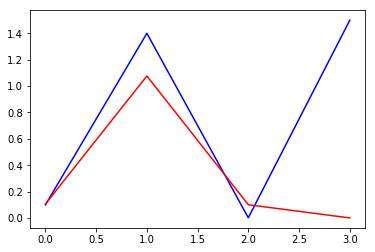

... 0.33519041144407713 0.33705625421521285
... 0.33362828654937 0.33555786750264116
..........................
[0.09935133 1.40095962 0.00011021 1.49988413]
[0.10506119 1.0768744  0.1        0.        ]


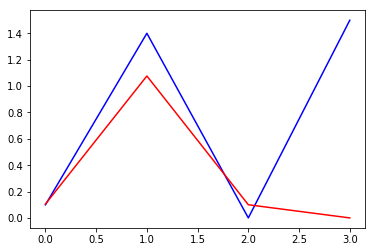

... 0.33517771873576896 0.33696528778687707
... 0.33362197604172666 0.3355526388442207
..........................
[ 0.09935289  1.40098161 -0.00006979  1.49988411]
[0.10506119 1.0768744  0.1        0.        ]


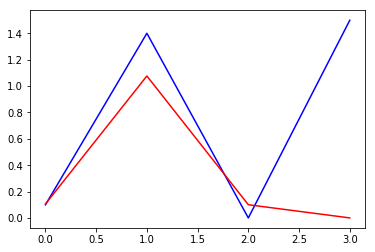

... 0.335360460223678 0.33719091491198155
... 0.33372626402168926 0.3357427361071363
..........................
[0.09935191 1.40096769 0.00055077 1.49988412]
[0.10506119 1.0768744  0.1        0.        ]


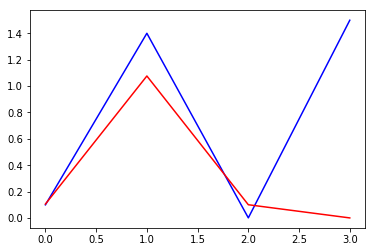

... 0.335834677609904 0.33784387880551875
... 0.33402922740918783 0.3362243307660458
..........................
[0.09935971 1.40107756 0.00196692 1.49988404]
[0.10506119 1.0768744  0.1        0.        ]


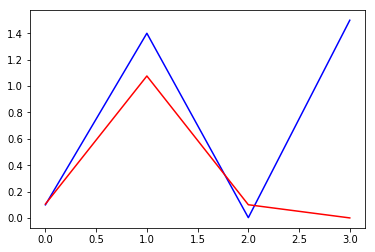

... 0.33669649396217805 0.3390376962283341
... 0.3346182440568157 0.3370936325199078
..........................
[0.09938758 1.40146996 0.00416733 1.49988374]
[0.10506119 1.0768744  0.1        0.        ]


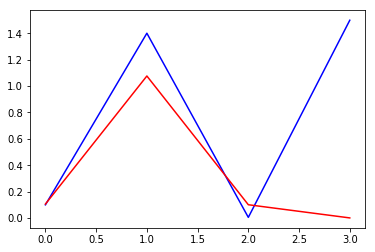

... 0.33804274473306795 0.3408898795687438
... 0.33558026456064394 0.33844751829570124
..........................
[0.09944664 1.40230133 0.00713441 1.4998831 ]
[0.10506119 1.0768744  0.1        0.        ]


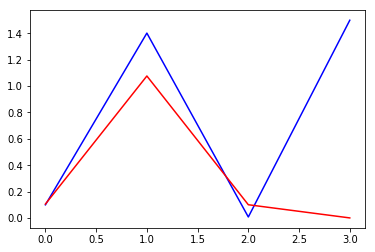

... 0.33997189042332426 0.34352334120209715
... 0.3370023934506519 0.3403844455235715
... 0.3344565623252973 0.3374741539215273
..........................
[0.09954774 1.40372463 0.01084441 1.49988201]
[0.10506119 1.0768744  0.1        0.        ]


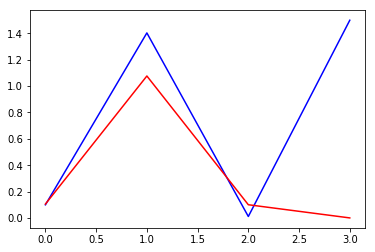

... 0.3425851402606766 0.3470678791589504
... 0.3389727277425792 0.3430055790460725
... 0.33598350846569053 0.33944987102191304
... 0.3334694860088766 0.33651384412274676
..........................
[0.09970141 1.40588806 0.01526765 1.49988033]
[0.10506119 1.0768744  0.1        0.        ]


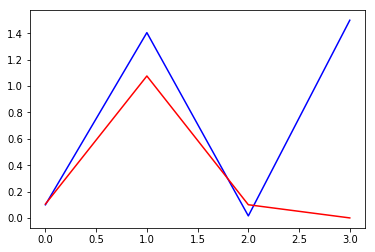

... 0.3459877055875902 0.3516616364178488
... 0.34158138884305067 0.34641605024890737
... 0.33805280969783374 0.3420645068607594
... 0.33516578908675776 0.3385866455752228
... 0.3327612018845207 0.3357477013470359
..........................
[0.09991778 1.40893391 0.02036876 1.49987795]
[0.10506119 1.0768744  0.1        0.        ]


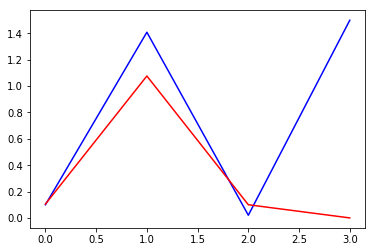

... 0.3502900940235938 0.35745242348066775
... 0.3449216742175997 0.3507262592784282
... 0.3407501658748351 0.3454115993659328
... 0.33742305096618097 0.34128829955310697
... 0.3347109297422281 0.33800672048929026
..........................
[0.10020644 1.41299742 0.02610691 1.49987473]
[0.10506119 1.0768744  0.1        0.        ]


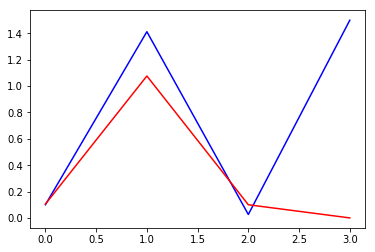

... 0.3556093511753539 0.3645987954157239
... 0.34909124840293787 0.35605312683088475
... 0.3441646737357525 0.34958905130410994
... 0.34032655948165436 0.3447081824918866
... 0.3372593920585773 0.3409126807175
... 0.334755497376971 0.337886917197737
..........................
[0.10057644 1.41820568 0.03243621 1.49987055]
[0.10506119 1.0768744  0.1        0.        ]


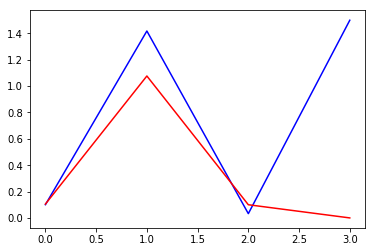

... 0.3620701558848767 0.37327078025487137
... 0.35419328912496556 0.3625212011371114
... 0.34838988823214884 0.3547002784058966
... 0.34396551182460927 0.3489401135438087
... 0.3404936499720672 0.34455495704121475
... 0.3377023626086732 0.34112151583187816
... 0.3354121073034373 0.3383687011011364
..........................
[0.10103616 1.42467661 0.03930602 1.49986524]
[0.10506119 1.0768744  0.1        0.        ]


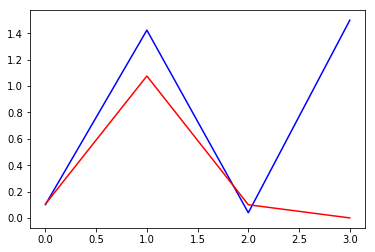

... 0.3698056777900403 0.3836501653537303
... 0.36033750362666467 0.37026352848367067
... 0.35352480661973035 0.3608552283997905
... 0.34843390466420787 0.3540833398659767
... 0.3445051527531361 0.3490276917858716
... 0.341389996880381 0.3451337441026725
... 0.3388631963325566 0.3420543829293816
..........................
[0.1015933  1.43251805 0.04666138 1.49985867]
[0.10506119 1.0768744  0.1        0.        ]


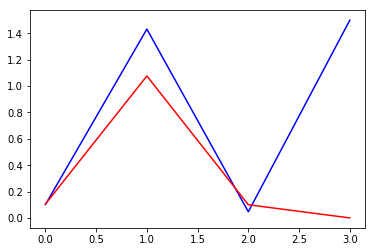

... 0.3789581122595726 0.3959302617815841
... 0.36764093286374755 0.3794222018471651
... 0.3596746987003632 0.3681711884262594
... 0.35383130264869533 0.3602433692641382
... 0.34939042350799593 0.35443056810067847
... 0.3459130009441414 0.35002011337122996
... 0.3431209716774026 0.346575205884415
... 0.3408317801560768 0.34381785720790126
..........................
[0.10225475 1.44182685 0.05444345 1.49985065]
[0.10506119 1.0768744  0.1        0.        ]


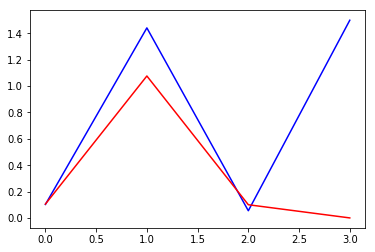

... 0.3896788173763072 0.41031508358487234
... 0.37622846693176026 0.39014851179400345
... 0.3669517102812293 0.37677330398378694
... 0.3602634173454036 0.36753257708527654
... 0.3552515791540061 0.36086939576031
... 0.35137114387664775 0.35588270092921354
... 0.348283391466161 0.35203078942579874
... 0.34576972152223306 0.3489751760388343
..........................
[0.10302661 1.45268815 0.06258997 1.49984102]
[0.10506119 1.0768744  0.1        0.        ]


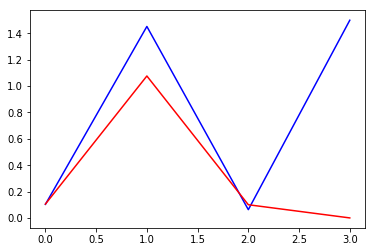

... 0.4021279902855814 0.42701789833748477
... 0.38623300378154823 0.4026026364221931
... 0.37547517341627573 0.38679474123449753
... 0.36784243389018445 0.37607052070792807
... 0.36219662592712 0.3684564462216181
... 0.3578696170281472 0.3628294585876394
... 0.3544534659652044 0.35852616003844734
... 0.3516891576866542 0.3551390681117006
..........................
[0.10391408 1.46517465 0.07103578 1.49982956]
[0.10506119 1.0768744  0.1        0.        ]


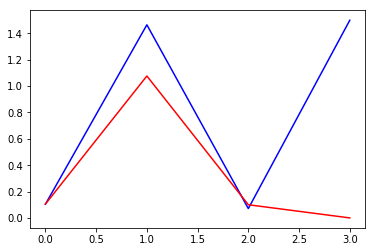

... 0.416473835504311 0.44625912712689714
... 0.39779519469492514 0.4169528223997414
... 0.3853715661165773 0.3983764359029399
... 0.37668703030105927 0.38598390406596556
... 0.3703394784125275 0.3773104815188379
... 0.3655190342667259 0.3709742464156218
... 0.3617392373519727 0.3661717705863366
... 0.3586959506053235 0.36241734454312924
... 0.3561915573347312 0.35940552713165463
..........................
[0.10492147 1.47934604 0.07971329 1.49981608]
[0.10506119 1.0768744  0.1        0.        ]


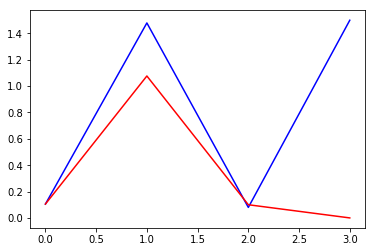

... 0.43289119521435954 0.46826359532520995
... 0.4110627337710391 0.4333740265999577
... 0.39677407567810347 0.41166638578011394
... 0.3869220443303809 0.39740614607789854
... 0.37979965893554635 0.38755643145132596
... 0.37443513747498863 0.3804365478868128
... 0.37025348391777896 0.37508322613232575
... 0.36690038708660827 0.3709225845168512
... 0.36414861226414974 0.3675987323513853
..........................
[0.10605214 1.49524856 0.0885531  1.49980033]
[0.10506119 1.0768744  0.1        0.        ]


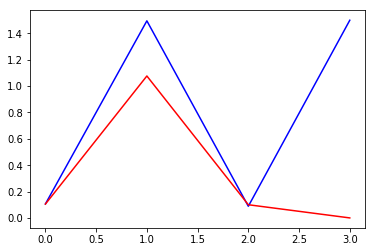

... 0.45155963057996434 0.4932571594012324
... 0.4261891643770168 0.45204600688550234
... 0.40982173321507337 0.4268184595566835
... 0.39867775457278126 0.4104765202778951
... 0.3907016448338387 0.39932468532633836
... 0.3847381760771667 0.3913408333273952
... 0.3801131187007301 0.3853806842253289
... 0.37641659221312695 0.38077155812752084
... 0.3733889505335915 0.37710167867907163
..........................
[0.10730846 1.51291456 0.09748449 1.49978209]
[0.10506119 1.0768744  0.1        0.        ]


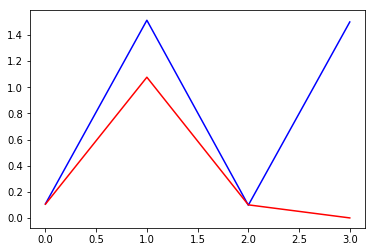

... 0.47266096311455785 0.5214627588563842
... 0.44333219263759105 0.47315087063081035
... 0.4246581019735886 0.44399071184790423
... 0.41208875593416133 0.4253388479263138
... 0.4031738433136284 0.41274997788851836
... 0.39655194063628096 0.40381555071426756
... 0.3914382630999181 0.39718790888696254
... 0.38736163426081266 0.3920843236704598
... 0.38402701934122574 0.3880313599517776
... 0.3812420105034411 0.38473061421409865
..........................
[0.10869186 1.53236232 0.106436   1.4997611 ]
[0.10506119 1.0768744  0.1        0.        ]


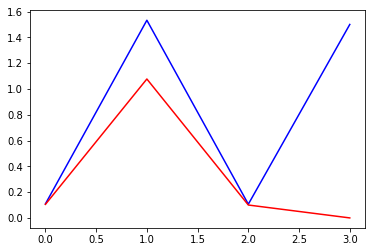

... 0.49637630542137595 0.5530959653208666
... 0.46265151602013393 0.49687010993899083
... 0.4414295180479203 0.46334321228014846
... 0.42729242406732776 0.4421397429311011
... 0.41734718687862943 0.42796986356568156
... 0.41000244290003307 0.41799173615341984
... 0.40435098762104066 0.41063096986519715
... 0.39985431315011005 0.4049829905990504
... 0.3961788340069612 0.40050661698695816
... 0.3931090281758429 0.39686420675695727
..........................
[0.11020273 1.55359583 0.11533602 1.4997371 ]
[0.10506119 1.0768744  0.1        0.        ]


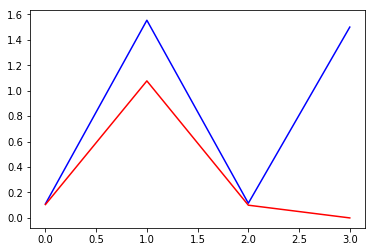

... 0.5237359585855882 0.5890539388279211
... 0.48525481654261765 0.5242330551921187
... 0.46129161856029977 0.4859821208077249
... 0.4454759262108561 0.4620332362743441
... 0.43443082867887933 0.4461699628610881
... 0.42631501157427004 0.43507706687739245
... 0.42008907909785287 0.42693375648623955
... 0.415142375945765 0.42070389960700766
... 0.411100345664994 0.4157737055380758
... 0.4077230908956254 0.41176379706931965
..........................
[0.11184049 1.57660482 0.12411335 1.4997098 ]
[0.11475954 1.0768744  0.1        0.        ]


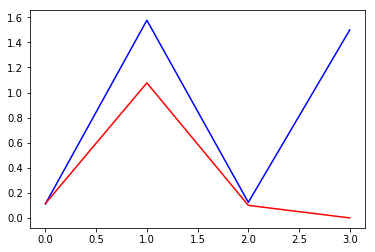

... 0.5531648850268127 0.6280862189088591
... 0.5093692600144955 0.5536681032445837
... 0.48234468164572675 0.5101387970130492
... 0.464653297260296 0.4831237013051016
... 0.45237690393080987 0.46536811553875024
... 0.44339518007369216 0.45302725580478015
... 0.4365215611940605 0.44400528992241456
... 0.43106530672623566 0.437119609872719
... 0.4266065143417203 0.43167580591367605
... 0.42287837385899824 0.4272482856443241
... 0.4197040324560334 0.4235647630530228
..........................
[0.11360356 1.6013648  0.13269778 1.49967896]
[0.11475954 1.0768744  0.1        0.        ]


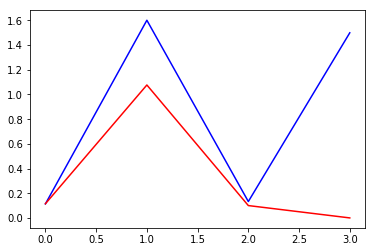

... 0.5857086718757121 0.6710963256921308
... 0.5361208652884525 0.586220072004195
... 0.5057628309288152 0.5369378278447864
... 0.4860292977370355 0.5065837472377968
... 0.4724110179583179 0.4867676676386545
... 0.4624836513147326 0.47306661289162033
... 0.45490067833157094 0.46308505848739046
... 0.4488845652534907 0.45548118118498887
... 0.44396640943494764 0.44947317727105646
... 0.4398503928497814 0.4445854893181118
... 0.43634157036071275 0.4405158857087797
..........................
[0.11548939 1.62783727 0.14102062 1.49964429]
[0.11475954 1.0768744  0.1        0.        ]


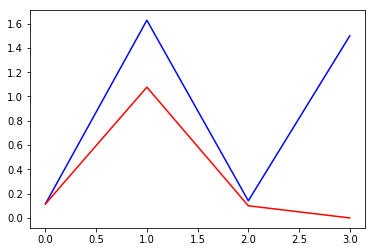

... 0.6215079063379865 0.7182195911674196
... 0.565647252748844 0.622030285603407
... 0.5316778903453071 0.5665172803041961
... 0.5097295662082555 0.5325455761441057
... 0.4946531613400443 0.5104946616703622
... 0.48369556684869297 0.49531559444226597
... 0.475337512799975 0.48428874150381673
... 0.4687078613414449 0.4759003052642181
... 0.4632849336536093 0.469274206248135
... 0.4587416978761493 0.4638810497720577
... 0.4548637461377944 0.45938636271700223
..........................
[0.11749448 1.65597003 0.1490153  1.49960553]
[0.11475954 1.0768744  0.1        0.        ]


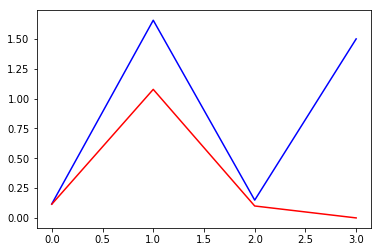

... 0.660682323515074 0.769558061579484
... 0.5980714418403439 0.6612192852016869
... 0.56021005621558 0.5990006272643936
... 0.5358695558614602 0.5611297859910196
... 0.5192138780405943 0.536665018246326
... 0.507137043760496 0.5198853142615202
... 0.497934405326249 0.5077231314464474
... 0.49063438597746106 0.498480094746261
... 0.4846586672363146 0.49117894020978314
... 0.4796466999354363 0.48523247659972046
... 0.4753631557808383 0.480271597608764
... 0.4716477725983731 0.47605388556137807
..........................
[0.11961439 1.6856976  0.15661786 1.49956245]
[0.11475954 1.0768744  0.1        0.        ]


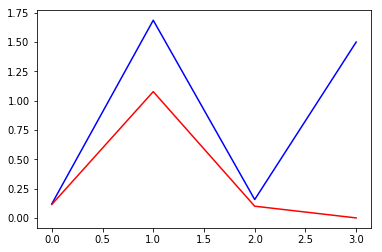

... 0.7033263987408563 0.8251755341051984
... 0.6334979045922287 0.703882407078606
... 0.591464320372121 0.6344927935959253
... 0.5645512484388893 0.5924417899006459
... 0.5461912068364371 0.5653812477932116
... 0.5329022944550476 0.5468744833942586
... 0.5227822157706501 0.5334832519112388
... 0.5147521845981607 0.5233123415207228
... 0.5081733323966688 0.5152764573741223
... 0.5026492103831343 0.5087266076588135
... 0.497922033463177 0.5032565856434601
... 0.4938167112320753 0.49860052216489636
..........................
[0.1218438  1.71694174 0.16376747 1.49951482]
[0.11475954 1.0768744  0.1        0.        ]


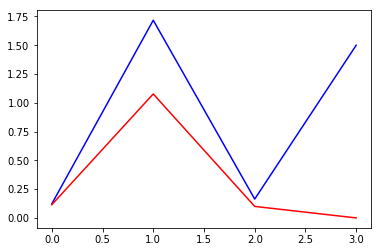

... 0.7503700274788386 0.8857203052768892
... 0.6730135315097134 0.750948728471069
... 0.6266185274716213 0.6740787105563344
... 0.5970087647426697 0.6276575457886536
... 0.5768567796243205 0.5978760089881162
... 0.562289872418497 0.5775537001333305
... 0.5512001166497654 0.5628669375437455
... 0.5423970618691266 0.5517156798576168
... 0.5351786804492487 0.5429020865234249
... 0.5291110092969172 0.5357126882878372
... 0.5239127479679727 0.529702503393173
... 0.5193932447168977 0.5245811048969987
..........................
[0.12417655 1.74961205 0.17040695 1.49946243]
[0.12473553 1.0768744  0.1        0.        ]


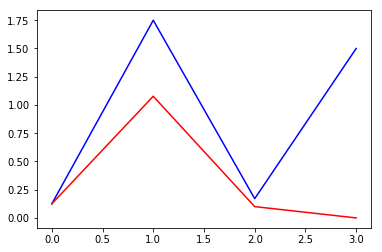

... 0.8000656219942722 0.9498501829245348
... 0.7146224195637056 0.8006749556577699
... 0.663515746339119 0.7157676153404111
... 0.6309747333063825 0.6646251295998199
... 0.6088633623755955 0.6318865997981123
... 0.5928920396490213 0.609580152590372
... 0.5807327067486328 0.5934707984118681
... 0.5710748510102185 0.581239152664872
... 0.5631481885865086 0.571566339192966
... 0.5564779924987905 0.5636692096020092
... 0.5507572741438931 0.5570606651889202
... 0.5457783034325364 0.5514234749566929
... 0.5413947317636701 0.54654202774592
..........................
[0.12660564 1.78360677 0.17648317 1.49940514]
[0.12473553 1.0768744  0.1        0.        ]


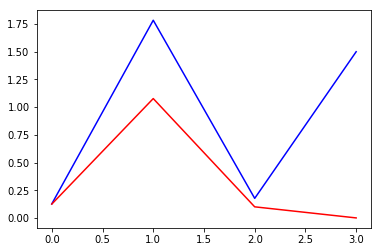

... 0.8533205053081138 1.018177359248355
... 0.7593960627923908 0.8539676630343257
... 0.7033220007122672 0.7606290807376775
... 0.667673289853903 0.7045087577690473
... 0.6434735881559638 0.6686358324440626
... 0.6259989151460766 0.6442156342937949
... 0.6126910725804138 0.6265844736932779
... 0.6021135028605666 0.6131935809953531
... 0.5934239185892833 0.6025969872054008
... 0.5861043708678304 0.5939380406949473
... 0.5798205001765891 0.5866850023623784
... 0.5743463018171975 0.5804921032778464
... 0.5695226221258279 0.575124561664058
..........................
[0.12912337 1.81881349 0.18194752 1.49934281]
[0.12473553 1.0768744  0.1        0.        ]


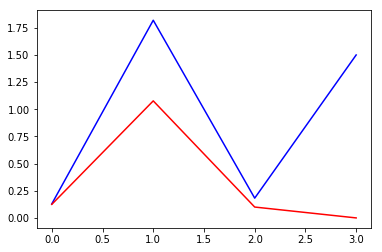

... 0.9100892121043167 1.09057387223647
... 0.8073276198396196 0.9107822774930879
... 0.7460467572669072 0.808656621872304
... 0.7071201673822037 0.7473183262309931
... 0.6807051433813577 0.7081401367622072
... 0.661628438060025 0.681478819446208
... 0.6470928528260012 0.662227142504032
... 0.6355302748234771 0.6475980417186973
... 0.6260228363560555 0.6360128736109918
... 0.6180069508755003 0.6265378387723571
... 0.6111191978762867 0.6185940861002804
... 0.6051140790806498 0.6118055758037875
... 0.5998187331687759 0.6059171050634694
... 0.5951070483438904 0.6007486640176031
..........................
[0.13172132 1.85511014 0.18675629 1.49927538]
[0.12473553 1.0768744  0.1        0.        ]


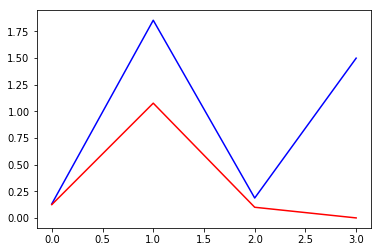

... 0.971226301251278 1.16750407488638
... 0.8594911770847469 0.9719721624327483
... 0.7928922356649505 0.8609217557034735
... 0.750597567838676 0.7942537128993707
... 0.7218940583977687 0.7516800385988613
... 0.7011556420168845 0.7227047009379465
... 0.6853432167612663 0.7017732606044036
... 0.6727548342826193 0.6858573856310061
... 0.6623952936555941 0.6732434332863656
... 0.653654036543789 0.6629186744960336
... 0.646137568357994 0.6542557928989969
... 0.63958012543953 0.6468474520645286
... 0.6337945465267512 0.640417247982027
... 0.6286442243054524 0.6347701829146383
..........................
[0.13439044 1.89236591 0.19087102 1.49920282]
[0.13499916 1.0768744  0.1        0.        ]


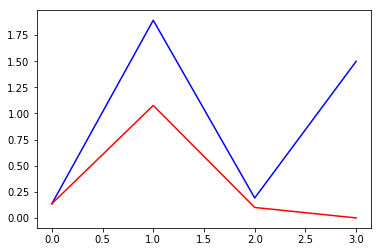

In [13]:
from Data_Processor import Data_Processor
from matplotlib import pyplot as plt
env=ENV()
dp =Data_Processor(_speed=.1,tlen=15)
#dp.update_trajectory(traj)
X,traj = env.reset(yaw=1.5)
U=np.zeros((NU,T),dtype=np.float64)

#traj=dp.update_trajectory(traj.T)

_dt=0.2
_dl=1.0
_tstep=5

for i in range(100):
    
    f_traj=dp.update_trajectory(traj)
    _xref,_=dp.get_ref_trajectory(X,_dl,_dt,_tstep)
    #_,_,U=sim_n_steps(X.array(),U,_xref)
    iLQR.ilqr(X.array(),U,_xref)
    #print(U)
    X,traj=env.step(U[0,1],U[1,1])
    print('..........................')
    print(X.array())
    print(_xref[:,0])
    #plt.cla()
    plt.plot(X.array(),color='b')
    plt.plot(_xref[:,0],color='r')
    plt.show()

In [15]:
traj

array([[0.13499916, 1.0768744 ],
       [0.1455608 , 1.0768744 ],
       [0.15643117, 1.0768744 ],
       [0.16762131, 1.0768744 ],
       [0.17914261, 1.0768744 ],
       [0.19100681, 1.0768744 ],
       [0.20322594, 1.0768744 ],
       [0.21581235, 1.0768744 ],
       [0.22877869, 1.0768744 ],
       [0.24213786, 1.0768744 ],
       [0.25590299, 1.0768744 ],
       [0.27008742, 1.0768744 ],
       [0.28470462, 1.0768744 ],
       [0.29976816, 1.0768744 ],
       [0.31529166, 1.0768744 ]])

In [10]:
aa=np.array([1,2,3,4,5,6,7,8],dtype=np.float64)
np.clip(aa,a_min=2,a_max=5)

array([2., 2., 3., 4., 5., 5., 5., 5.])